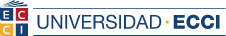
# **SISTEMAS AVANZADOS DE PRODUCCIÓN CON PYTHON**

# **Taller 5 (8h): Ejecución del proyecto en Notebook**



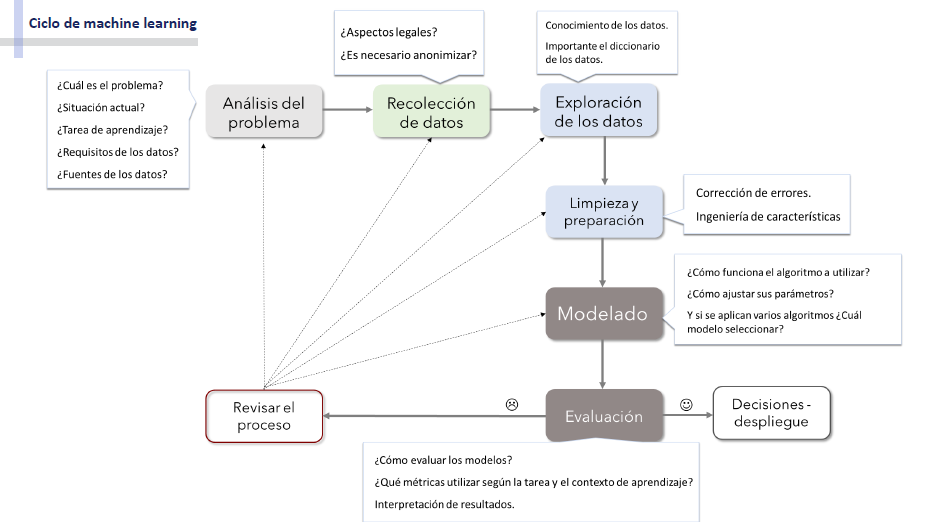


**Objetivo general**

Seguir el ciclo de ML del diagrama para resolver tu problema con dos rutas posibles: Regresión o Clasificación. Documenta cada paso en el notebook.


**Objetivos de la sesión**

---

### **Clase 1: Ruta A — Problema de Regresión 🛠️**

* En esta ruta seguiremos el ciclo completo de machine learning: análisis del problema, recolección de datos, exploración, y limpieza y preparación, para luego pasar al modelado y evaluación. El foco estará en predecir un valor continuo usando un baseline de regresión lineal y una red neuronal para regresión. Ten en cuenta que el orden y la profundidad de cada paso pueden variar según el dataset de cada grupo (por ejemplo, si ya viene limpio o si requiere más ingeniería de variables). Documentaremos claramente cada decisión tomada, las métricas usadas (MAE/RMSE) y las conclusiones.

---

### **Clase 2: Ruta B — Problema de Clasificación🌳**

* Aquí aplicaremos el mismo ciclo: análisis del problema, recolección de datos, exploración, y limpieza y preparación, seguido de modelado y evaluación. Clasificaremos casos binarios comparando regresión logística, perceptrón y un árbol aleatorio (Random Forest). El flujo podrá ajustarse según las características de los datos de cada equipo (por ejemplo, manejo de desbalance o codificación de categorías). Dejaremos registradas las decisiones de preprocesamiento, la elección de la métrica (p. ej., F1/ROC-AUC) y la definición del umbral cuando corresponda.




# **Semana 11 - Clase 1**


  


## 🧭 **Análisis del problema — Bike Sharing (UCI)**

- **Problema de negocio (qué decisión habilita):**
Predecir la **demanda diaria/horaria de bicicletas** para **planear capacidad** (flota, redistribución, turnos y mantenimiento), evitando **quedarse corto** (pérdida de ventas/servicio) o **sobredimensionar** (costos operativos altos).

- **Situación actual (contexto):**
La empresa dispone de históricos de alquileres y clima, pero decide de forma **reactiva**. Se requiere una **estimación confiable** de la demanda para calendarizar personal y mover inventario (bicicletas) con anticipación.

- **Tarea de aprendizaje:**
**Regresión supervisada.** Variable objetivo continua: **`cnt`** = número de alquileres (por **hora** o por **día**, según el archivo elegido).


<div align="center">
  <img src="https://storage.googleapis.com/kaggle-datasets-images/2690506/4623141/f2081a78ee21b5125855a896e8ff8b19/dataset-cover.jpg?t=2022-11-30-10-33-36" width="80%">
</div>

---

###**Requisitos de datos (mínimos):**

* Variables **exógenas ( no estan influidas por ruido u otras variables)** disponibles antes de la decisión: clima (`temp`, `humidity`, `windspeed`, `weather`) y calendario (`season`, `holiday`, `workingday`, `hour/weekday`).
* **Calidad aceptable:** $<$5–10$\%$ de datos nulos manejables, tipificación correcta y **sin fuga de información**.

###**Fuentes de datos:**

* **UCI Bike Sharing Dataset** (público): archivos **`day.csv`** / **`hour.csv`**.

    En este caso se puede acceder al recurso original, el cual es:

    https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

* **Diccionario de variables** provisto en el repositorio original.

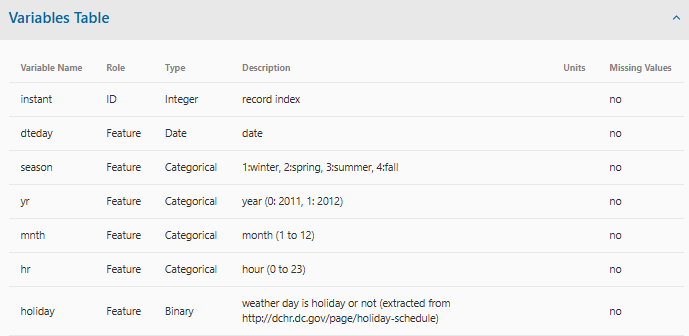

###**Criterio de éxito (métrica + umbral de negocio):**

* Métrica principal: **RMSE** (o **MAE** si hay outliers relevantes).
* Objetivo operativo (ejemplo): **RMSE ≤ 15 alquileres/hora** o **MAE ≤ 10**, consistente en test.

###**Riesgos y supuestos:**

* **Estacionalidad/feriados** impactan fuertemente la demanda.
* **Cambios de política** o eventos atípicos pueden romper patrones.
* No se usan datos personales; dataset **agregado y no sensible**.


### 📥 **Recolección de datos — Bike Sharing (UCI)**

Usaremos el dataset público **UCI Bike Sharing**. Página del repositorio: [https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). Descarga directa (ZIP): [https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip). Trabajaremos con **una sola granularidad** (día `day.csv` u hora `hour.csv`) y registraremos en el notebook el **enlace de origen** y la **fecha de descarga** para trazabilidad. Antes de modelar, haremos una verificación básica: tipos correctos, rangos razonables y nulos manejables; variables clave: objetivo `cnt`, clima (`temp`, `humidity`, `windspeed`, `weather`) y calendario (`season`, `holiday`, `workingday`, `weekday`, `hour` si aplica).

**Aspectos legales y privacidad.** Este dataset es agregado y no contiene identificadores personales, por lo que **no requiere anonimización adicional** en uso académico. Si algún equipo lo combina con datos propios, debe documentar la finalidad, eliminar identificadores directos, agrupar o truncar campos sensibles y retener solo lo necesario, conforme a la **Ley 1581 de 2012 (Habeas Data)** en Colombia.


In [1]:
# ============================================================
# CARGA CORRECTA DEL DATASET "BIKE SHARING (UCI)" EN COLAB
# ------------------------------------------------------------
# Objetivo de esta celda:
# 1) Descargar el ZIP oficial desde UCI.
# 2) Descomprimirlo en el entorno de Colab.
# 3) Elegir la granularidad (día u hora) y cargar el CSV a pandas.
# 4) Convertir fechas a tipo datetime y revisar tipos de datos.
# 5) Mostrar un diccionario claro de variables (qué significa cada una).
# 6) Hacer verificaciones básicas: tamaño, nulos, muestra de filas.
# ------------------------------------------------------------
# Nota: Esta celda está MUY comentada a propósito, para personas
#       que están empezando con Python y Colab.
# ============================================================

import os
import io
import zipfile
import urllib.request
import pandas as pd

# ------------------------------------------------------------
# 1) CONFIGURACIÓN BÁSICA DEL PROYECTO (FÁCIL DE EDITAR)
# ------------------------------------------------------------

# Enlace oficial del ZIP en el repositorio UCI:
UCI_ZIP_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"

# El usuario puede elegir la granularidad aquí:
#   - "day"  -> carga el archivo day.csv  (agregado por día)
#   - "hour" -> carga el archivo hour.csv (agregado por hora)
GRANULARITY = "hour"  # <-- Cambia a "day" si quieres trabajar por día

# Carpeta donde guardaremos los archivos descomprimidos
DATA_DIR = "/content/bike_sharing_data"

# ------------------------------------------------------------
# 2) DESCARGA DEL ZIP DESDE UCI
#    No requiere instalar nada extra. Usamos la librería estándar.
# ------------------------------------------------------------
os.makedirs(DATA_DIR, exist_ok=True)
zip_path = os.path.join(DATA_DIR, "Bike-Sharing-Dataset.zip")

print("Descargando ZIP desde UCI (puede tardar unos segundos)...")
urllib.request.urlretrieve(UCI_ZIP_URL, zip_path)
print("Descarga completa:", zip_path)

# ------------------------------------------------------------
# 3) DESCOMPRESIÓN DEL ZIP
# ------------------------------------------------------------
print("Descomprimiendo archivos...")
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(DATA_DIR)

print("Contenido descomprimido en:", DATA_DIR)
print("Archivos disponibles:", os.listdir(DATA_DIR))

# ------------------------------------------------------------
# 4) ELECCIÓN DEL CSV SEGÚN LA GRANULARIDAD
# ------------------------------------------------------------
if GRANULARITY == "day":
    csv_path = os.path.join(DATA_DIR, "day.csv")
elif GRANULARITY == "hour":
    csv_path = os.path.join(DATA_DIR, "hour.csv")
else:
    raise ValueError("GRANULARITY debe ser 'day' u 'hour'.")

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"No se encontró el archivo esperado: {csv_path}")

print(f"Granularidad elegida: {GRANULARITY.upper()} -> Cargando {os.path.basename(csv_path)}")

# ------------------------------------------------------------
# 5) CARGA DEL CSV CON PANDAS
#    - parse_dates convierte la columna de fecha a tipo datetime (si existe).
#    - keep_default_na=True: pandas interpretará valores vacíos como NA.
# ------------------------------------------------------------
# En ambos CSV existe la columna 'dteday' (fecha). La parseamos si está presente.
parse_cols = ["dteday"]  # Si la columna no existe, pandas la ignorará.
df = pd.read_csv(csv_path, parse_dates=parse_cols, dayfirst=False, keep_default_na=True)

# ------------------------------------------------------------
# 6) DICCIONARIO DE VARIABLES
#    Explicamos, en español y de forma clara, qué significa cada columna.
#    (Puede que en tu CSV haya leves diferencias; este diccionario cubre lo estándar.)
# ------------------------------------------------------------
variable_dict = {
    # Identificadores / fecha
    "instant": "Índice de la fila (identificador incremental).",
    "dteday": "Fecha del registro (tipo datetime).",
    "season": "Estación del año (1: invierno, 2: primavera, 3: verano, 4: otoño) *codificación UCI.",
    "yr": "Año (0: primer año del dataset, 1: segundo año).",
    "mnth": "Mes del año (1 a 12).",
    "hr": "Hora del día (0 a 23) — solo en hour.csv.",
    "holiday": "Indica si el día es festivo (1) o no (0).",
    "weekday": "Día de la semana (0: domingo… 6: sábado).",
    "workingday": "Día laboral (1) o no (0) — excluye fines de semana y festivos.",
    # Clima
    "weathersit": "Situación del clima (1: bueno, 2: nubes/neblina, 3: lluvia ligera, 4: lluvia fuerte/nieve).",
    "temp": "Temperatura normalizada (0 a 1) — basada en temperatura en °C.",
    "atemp": "Temperatura aparente normalizada (sensación térmica).",
    "hum": "Humedad normalizada (0 a 1).",
    "windspeed": "Velocidad del viento normalizada (0 a 1).",
    # Objetivo y componentes
    "casual": "Número de alquileres por usuarios casuales (no registrados).",
    "registered": "Número de alquileres por usuarios registrados.",
    "cnt": "Número total de alquileres (objetivo para regresión)."
}

# Mostramos el diccionario como una tabla legible
dict_df = pd.DataFrame(
    [(k, variable_dict.get(k, "(desconocida en este diccionario)")) for k in df.columns],
    columns=["columna", "significado"]
)

print("\n=== DICCIONARIO DE VARIABLES (según columnas presentes) ===")
print(dict_df.to_string(index=False))

# ------------------------------------------------------------
# 7) ARREGLOS Y TIPOS DE DATOS
#    - Confirmamos que 'dteday' está en datetime.
#    - Revisamos tipos básicos y rangos.
# ------------------------------------------------------------
if "dteday" in df.columns:
    # Ya la parseamos como datetime en read_csv; confirmamos:
    print("\nTipo de 'dteday':", df["dteday"].dtype)

print("\n=== TIPOS DE DATOS (pandas dtypes) ===")
print(df.dtypes)

# ------------------------------------------------------------
# 8) VERIFICACIONES BÁSICAS DE CALIDAD
# ------------------------------------------------------------
print("\n=== DIMENSIONES DEL DATASET ===")
print("Filas:", len(df), "| Columnas:", df.shape[1])

print("\n=== NULOS POR COLUMNA (valores faltantes) ===")
print(df.isna().sum())



# ------------------------------------------------------------
# 9) SUGERENCIA PEDAGÓGICA
#    Si estamos en 'hour.csv', a menudo es útil crear una columna 'hour' si no existe,
#    o asegurar que 'hr' está en entero. También es buena práctica comprobar valores únicos.
# ------------------------------------------------------------
if GRANULARITY == "hour":
    # Aseguramos que hr sea entero (debería serlo ya).
    if "hr" in df.columns:
        df["hr"] = df["hr"].astype(int)
        print("\nValores únicos de 'hr' (deberían ser 0..23):", sorted(df["hr"].unique())[:10], "...")

# ------------------------------------------------------------
# 10) (OPCIONAL) GUARDAR UNA COPIA LIMPIA INICIAL
#     Esto ayuda a mantener una "versión base" antes de empezar la preparación.
# ------------------------------------------------------------
base_csv_path = os.path.join(DATA_DIR, f"base_{GRANULARITY}.csv")
df.to_csv(base_csv_path, index=False)
print(f"\nCopia base guardada en: {base_csv_path}")

# Listo: en las siguientes celdas se recomienda continuar con:
# - EXPLORACIÓN (estadísticos, gráficos básicos)
# - LIMPIEZA/PREPARACIÓN (nulos, tipos, escalado, codificación)
# - PARTICIÓN (train/test)
# - MODELADO (Regresión Lineal vs Perceptrón/Adaline/MLP)
# - EVALUACIÓN (MAE/RMSE y residuales)

Descargando ZIP desde UCI (puede tardar unos segundos)...
Descarga completa: /content/bike_sharing_data/Bike-Sharing-Dataset.zip
Descomprimiendo archivos...
Contenido descomprimido en: /content/bike_sharing_data
Archivos disponibles: ['Readme.txt', 'Bike-Sharing-Dataset.zip', 'hour.csv', 'day.csv']
Granularidad elegida: HOUR -> Cargando hour.csv

=== DICCIONARIO DE VARIABLES (según columnas presentes) ===
   columna                                                                                 significado
   instant                                              Índice de la fila (identificador incremental).
    dteday                                                         Fecha del registro (tipo datetime).
    season        Estación del año (1: invierno, 2: primavera, 3: verano, 4: otoño) *codificación UCI.
        yr                                            Año (0: primer año del dataset, 1: segundo año).
      mnth                                                                  

In [2]:
# Vista del data frame
print("\n=== VISTA RÁPIDA (head) ===")
df.head()


=== VISTA RÁPIDA (head) ===


instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1 2011-01-01       1   0     1   0        0        6           0   
1        2 2011-01-01       1   0     1   1        0        6           0   
2        3 2011-01-01       1   0     1   2        0        6           0   
3        4 2011-01-01       1   0     1   3        0        6           0   
4        5 2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

#

### 🔍 **Exploración y conocimiento de los datos — Bike Sharing (UCI)**

En esta fase buscamos **entender la forma y el contexto** del dataset antes de modelar. Revisamos tamaño (filas/columnas), tipos de variables, rangos y valores atípicos, y verificamos si la granularidad elegida (**día** u **hora**) cubre estacionalidad y feriados. La idea es detectar patrones generales (tendencias por clima y calendario), posibles **nulos** o codificaciones inusuales, y confirmar que la variable objetivo `cnt` refleja correctamente la demanda.

**Descripción breve.**
Empezamos con una síntesis: periodo cubierto, frecuencia (día/hora), medias y dispersiones de las variables numéricas, y distribución básica de `cnt`. Si existen transformaciones previas (p. ej., temperaturas normalizadas 0–1), se anotan para no duplicarlas. Si hay desbalance temporal (pocos registros en ciertos meses/horas), se documenta porque afectará la validación.

---

### 📚 **Diccionario de datos (significado de variables)**

| Variable     | Significado breve                                                           |
| ------------ | --------------------------------------------------------------------------- |
| `instant`    | Índice incremental del registro.                                            |
| `dteday`     | Fecha del registro (día).                                                   |
| `season`     | Estación (1 invierno, 2 primavera, 3 verano, 4 otoño).                      |
| `yr`         | Año (0 o 1 según el año en el dataset).                                     |
| `mnth`       | Mes (1–12).                                                                 |
| `hr`         | Hora del día (0–23, solo en `hour.csv`).                                    |
| `holiday`    | Indicador de festivo (1 sí, 0 no).                                          |
| `weekday`    | Día de la semana (0 domingo … 6 sábado).                                    |
| `workingday` | Día laboral (1 sí, 0 no; excluye fines de semana y festivos).               |
| `weathersit` | Clima (1 bueno, 2 nublado/neblina, 3 lluvia ligera, 4 lluvia fuerte/nieve). |
| `temp`       | Temperatura normalizada (0–1).                                              |
| `atemp`      | Sensación térmica normalizada (0–1).                                        |
| `hum`        | Humedad relativa normalizada (0–1).                                         |
| `windspeed`  | Velocidad del viento normalizada (0–1).                                     |
| `casual`     | Alquileres de usuarios casuales (no registrados).                           |
| `registered` | Alquileres de usuarios registrados.                                         |
| `cnt`        | **Objetivo**: total de alquileres (`casual + registered`).                  |

> Nota: algunas columnas son **categóricas codificadas como números** (p. ej., `season`, `weathersit`, `weekday`). Se interpretan como categorías, no como cantidades continuas.

---

### 🖼️ **Guía rápida para gráficos descriptivos**

**Histogramas** sirven para ver la **distribución** de una variable numérica (p. ej., `cnt`, `temp`, `hum`) y detectar asimetrías o multimodalidad. Úsalos cuando quieras responder “¿cómo se reparte esta variable?” o comparar distribuciones por subgrupos (ej., histograma de `cnt` por `season`).

**Box plots** son útiles para comparar **niveles y dispersión** entre **categorías** y detectar **outliers** (p. ej., `cnt` por `weekday`, `weathersit` o `hour`). Son ideales para responder “¿qué categoría tiende a tener valores más altos/estables?” y visualizar mediana y cuartiles.

**Series/line plots** (si trabajas por hora o día) muestran **tendencias y estacionalidad** en el tiempo (picos por hora punta, patrones de fin de semana). Ayudan a ver ciclos diarios/semanales y posibles quiebres.

**Relaciones bivariadas**: un **scatter** `temp` vs `cnt` sugiere relación con clima; un **scatter** `hr` vs `cnt` revela picos horarios. Si aparece curvatura o bandas, puede ser señal de **no linealidad** o de variables omitidas.

---


### **Qué dejamos documentado.**

Un párrafo con los **hallazgos descriptivos clave**: patrón de demanda por hora/día, efecto visible del clima y presencia de outliers o nulos. Además, reportamos **correlaciones** entre `cnt` y las variables numéricas con los coeficientes **de Pearson** (relación **lineal**) y **de Spearman** (relación **monótona**, robusta a no linealidades y outliers). Si Pearson es alto y Spearman similar, sugiere relación aproximadamente lineal; si Spearman es alto pero Pearson bajo, puede haber relación no lineal (o influencia de rangos). Esta evidencia guía la **preparación** (p. ej., transformaciones/escala) y anticipa si una **regresión lineal** podría bastar o si un **modelo no lineal** agregará valor.


In [3]:
!pip -q install ydata-profiling -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 4.0 MB/s eta 0:00:00


In [4]:
# Utilizamos la libreria recien instalada
from ydata_profiling import ProfileReport

profile = ProfileReport(df)
profile.to_notebook_iframe()  # lo embebe como iframe (funciona bien en Colab)
# Descarga el profile como archivo html
profile.to_file("reporte_perfil.html")
print("Archivo guardado:", "/content/reporte_perfil.html")



Output hidden; open in https://colab.research.google.com to view.

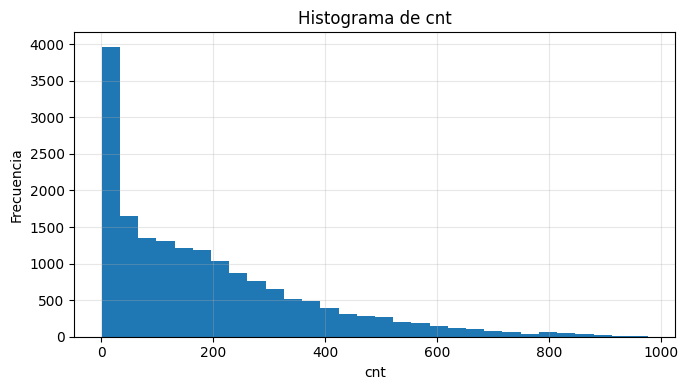

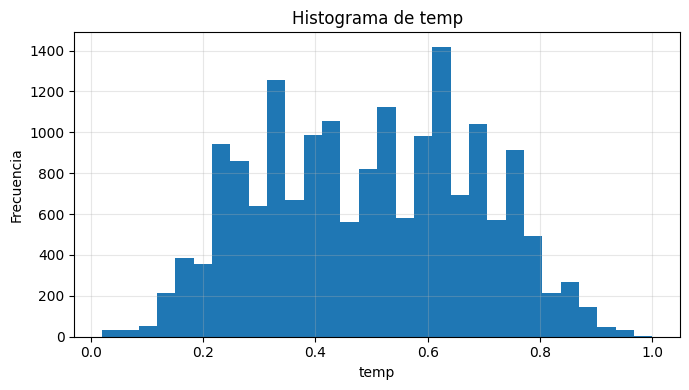

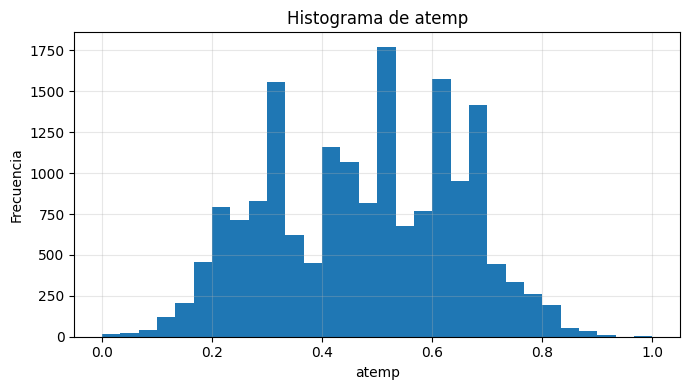

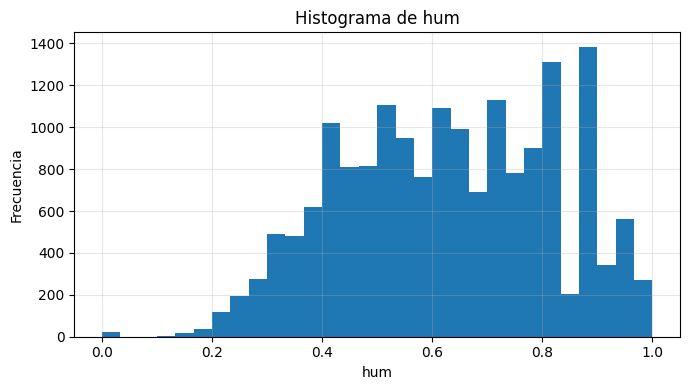

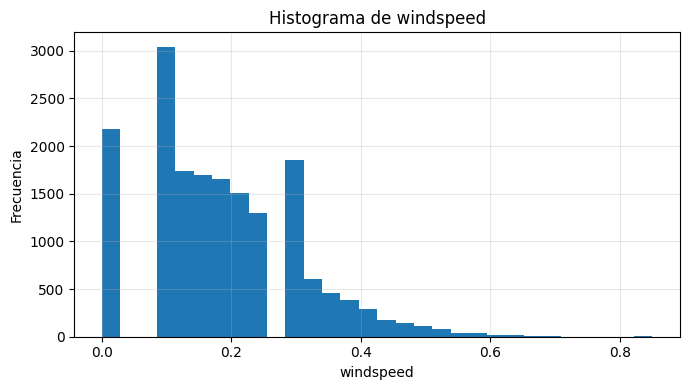

/tmp/ipython-input-2666669698.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


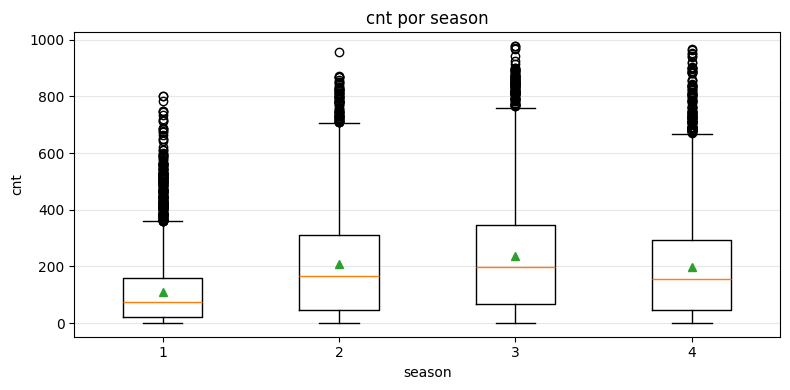

/tmp/ipython-input-2666669698.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


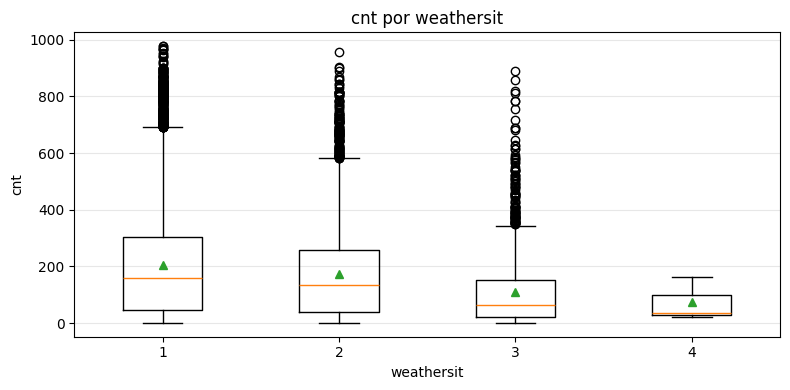

/tmp/ipython-input-2666669698.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


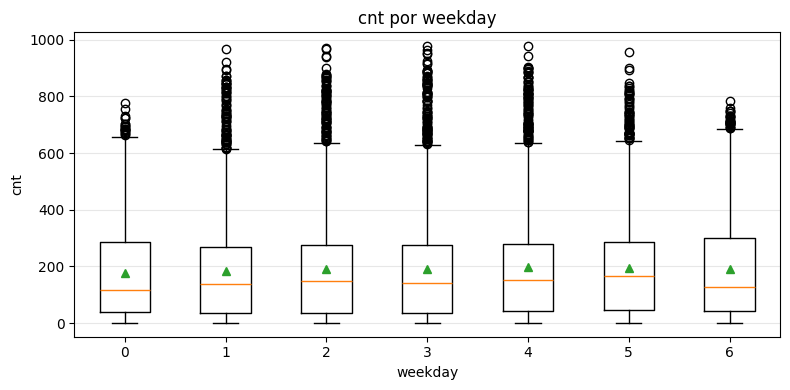

/tmp/ipython-input-2666669698.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


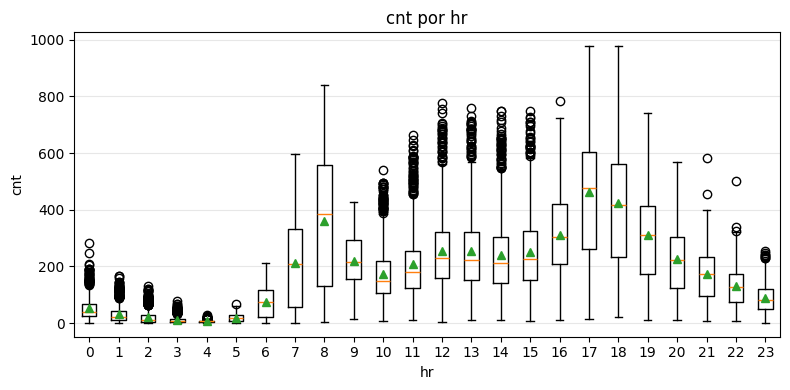

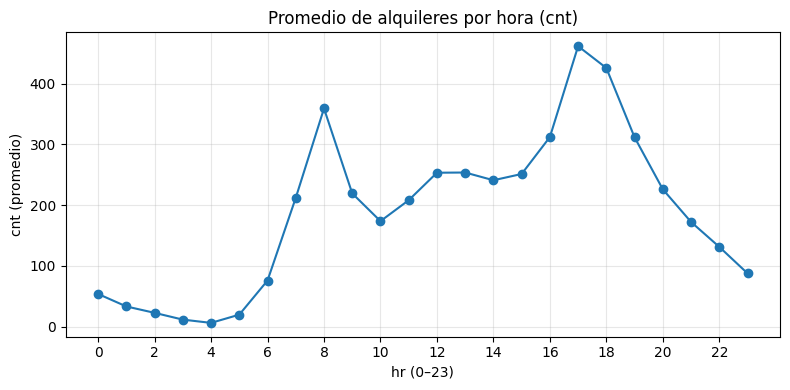

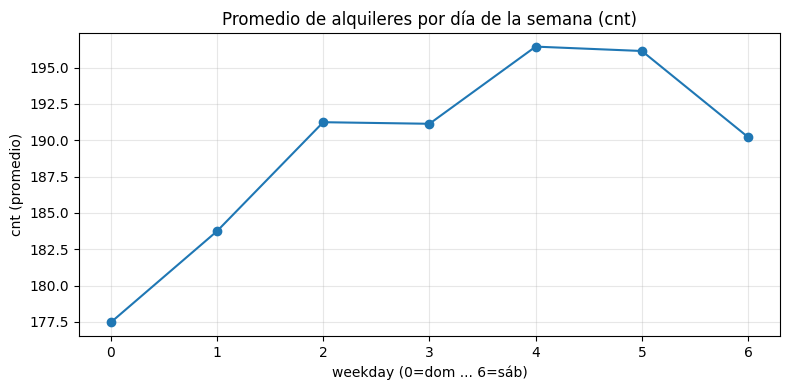

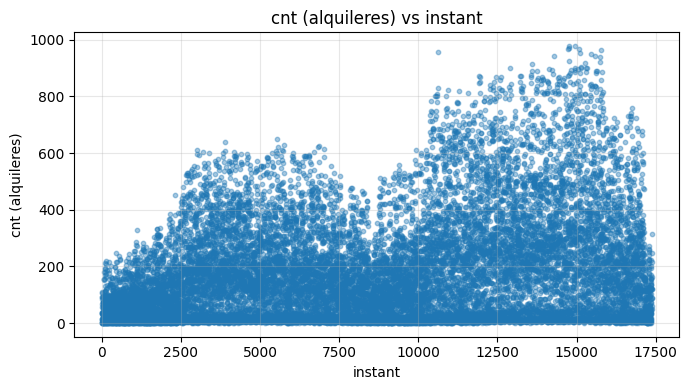

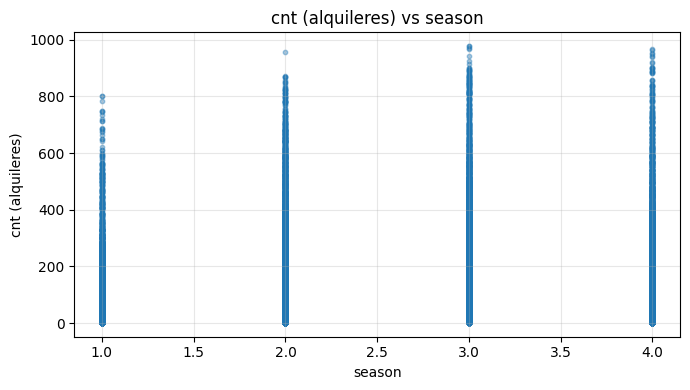

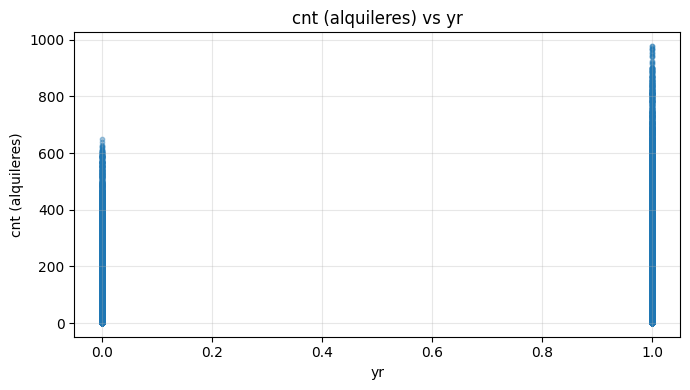

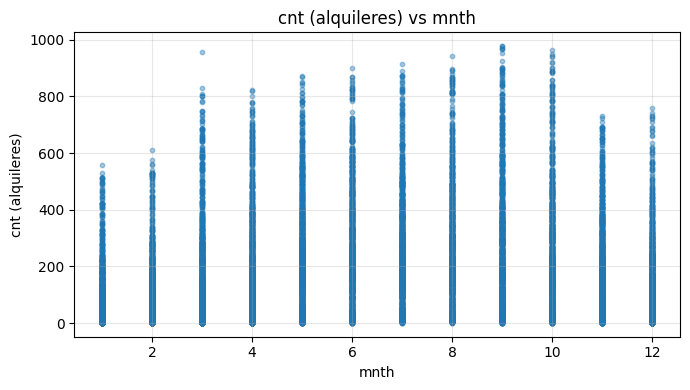

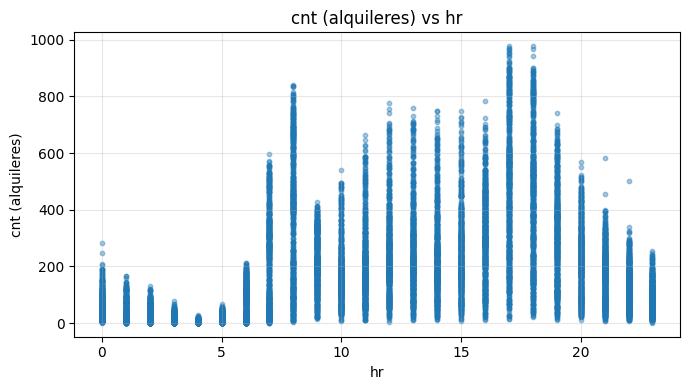

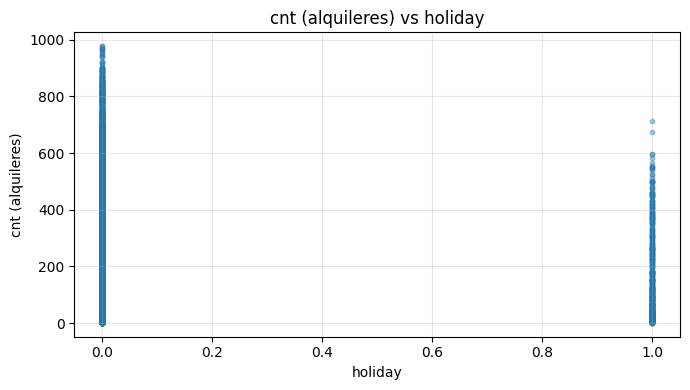

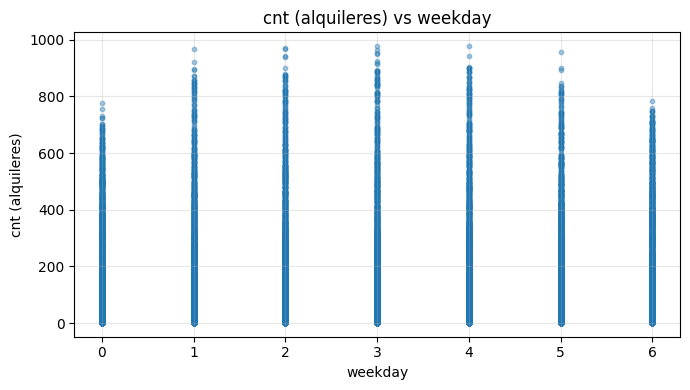

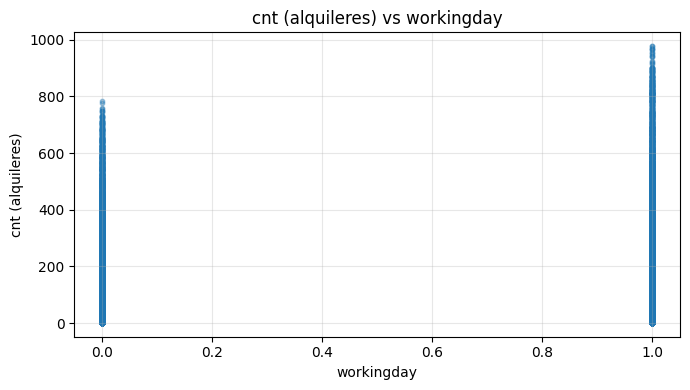

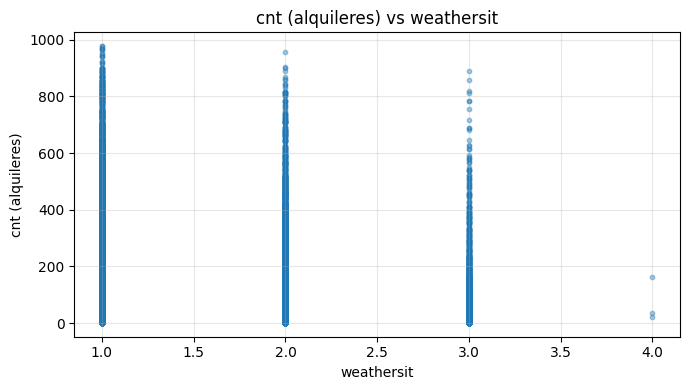

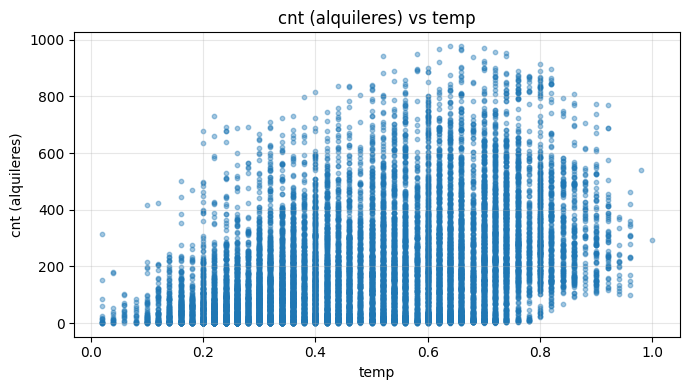

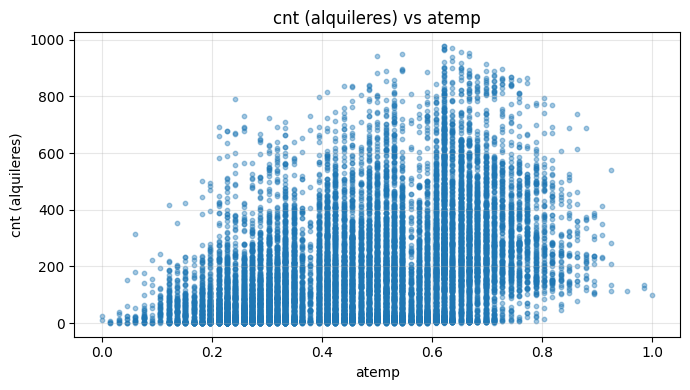

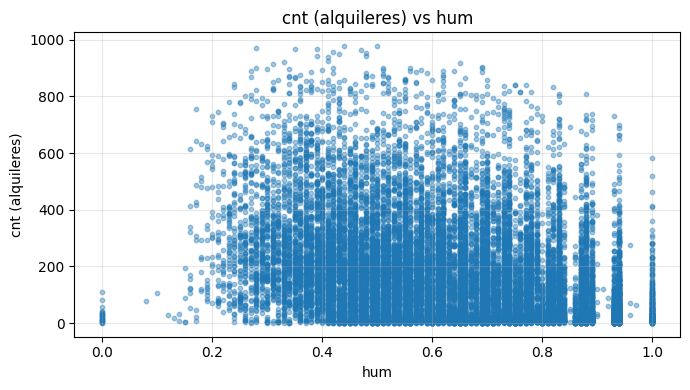

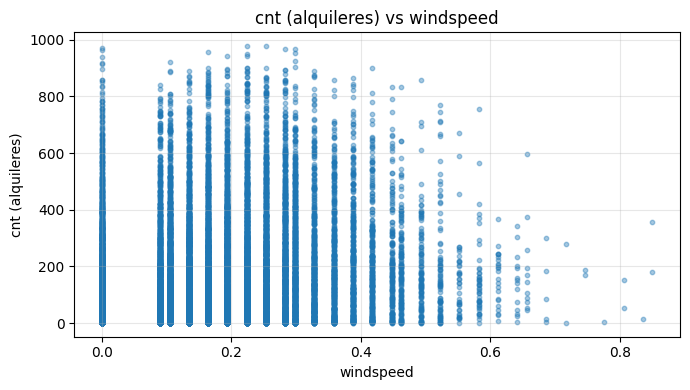

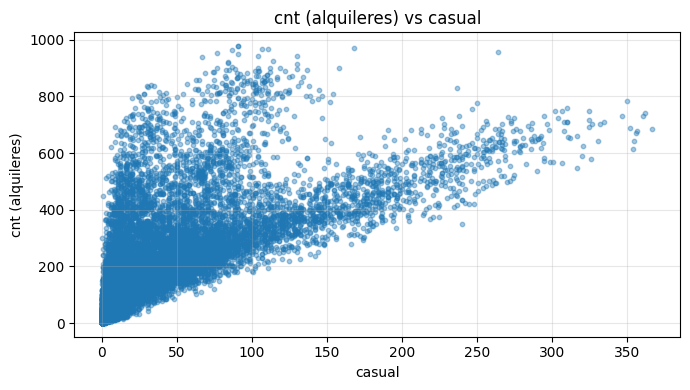

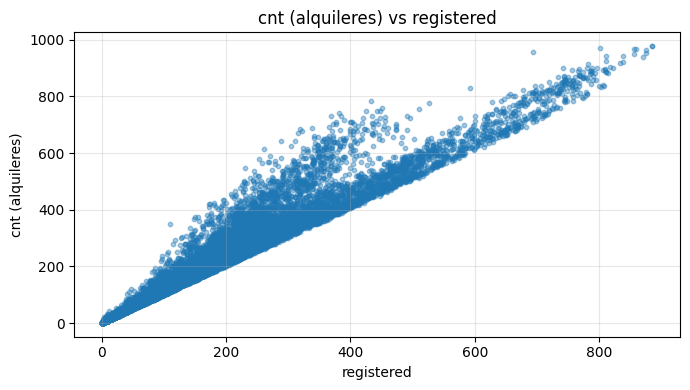

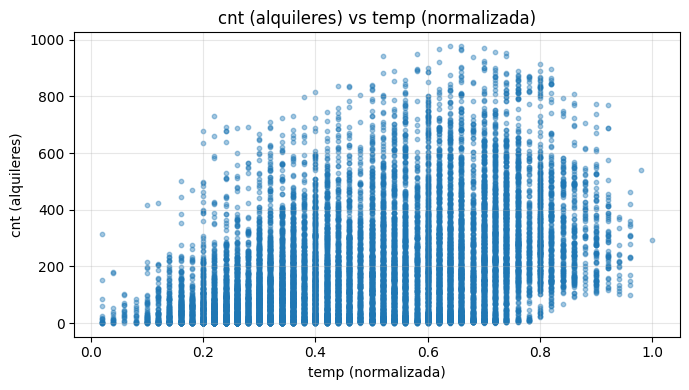

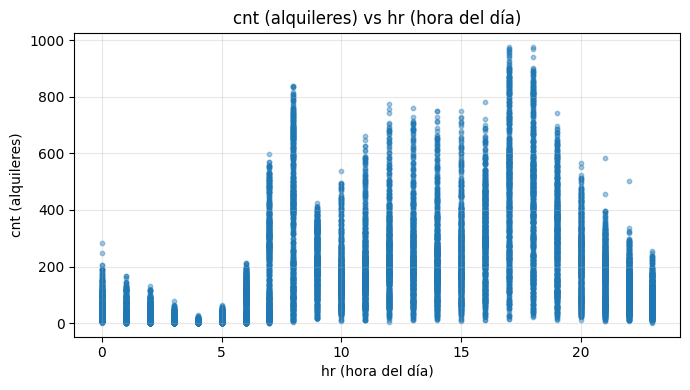


=== Correlación (Pearson) — top con cnt ===
cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

=== Correlación (Spearman) — top con cnt ===
cnt           1.000000
registered    0.989444
casual        0.850525
hr            0.510878
temp          0.423330
atemp         0.423258
instant       0.243742
yr            0.207500
season        0.185179
windspeed     0.126629
mnth          0.125889
weekday       0.030297
workingday    0.021033
holiday      -0.029526
weathersit   -0.126276
hum          -0.359614
Name: cnt, dtype: float64


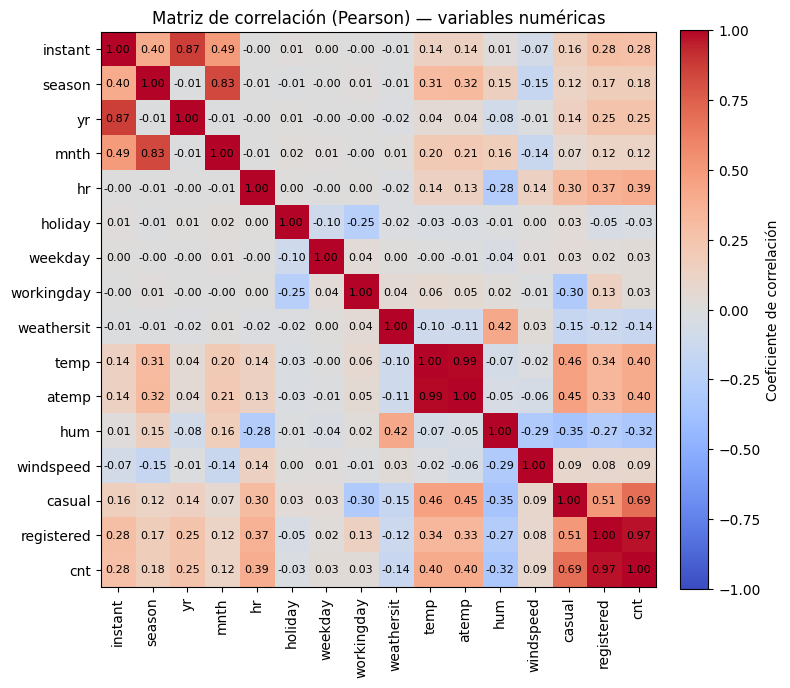

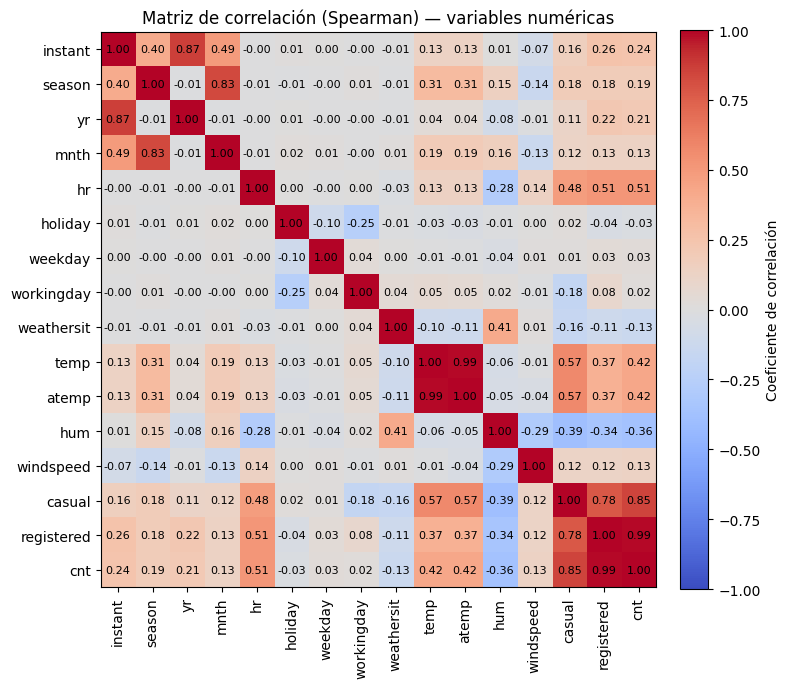


Guía de lectura:
- Histogramas: forma de cada variable (asimetría, colas, multimodalidad).
- Box plots: diferencias entre categorías (estación, clima, días) y outliers.
- Series: picos horarios y patrón por weekday (si trabajas por hora).
- Scatter: relaciones y posibles no linealidades (temp/hr vs cnt).
- Correlación: Pearson (lineal) y Spearman (monótona).
  Si Pearson y Spearman son similares y altos con cnt -> tendencia lineal;
  si Spearman es alto y Pearson bajo -> relación no lineal o efecto de rangos/outliers.


In [5]:
# Camino mas largo, pero enriqucedor para conocer otro tipo de gráficos.
# ============================================================
# EXPLORACIÓN DESCRIPTIVA — UCI Bike Sharing (day/hour)
# ------------------------------------------------------------
# Qué hace esta celda (paso a paso):
# 1) Grafica histogramas (forma de la distribución).
# 2) Grafica boxplots por categorías (estación, clima, etc.).
# 3) Grafica tendencias (promedios por hora / weekday).
# 4) Grafica relaciones (scatter) cnt vs temp / hr.
# 5) Calcula correlación Pearson y Spearman y dibuja heatmaps.
# ------------------------------------------------------------
# Requisitos: SOLO matplotlib y pandas (ya vienen en Colab).
# ============================================================

# ========== 0) CONFIGURACIÓN DEL PROYECTO ==========
GRANULARITY = "hour"  # Cambia a "day" para trabajar por día
PRIMARY_TARGET = "cnt"  # Variable objetivo de demanda total

# ========== 1) DESCARGA Y CARGA ==========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# ========== 1) HISTOGRAMAS ==========
# Qué vemos: forma de la distribución (asimetría, colas, multimodalidad)
numeric_cols = [c for c in ["cnt","temp","atemp","hum","windspeed"] if c in df.columns]
for col in numeric_cols:
    plt.figure(figsize=(7,4))
    plt.hist(df[col].dropna(), bins=30)  # No definimos color explícito
    plt.title(f"Histograma de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ========== 2) BOXPLOTS POR CATEGORÍAS ==========
# Qué vemos: diferencias de nivel y dispersión entre categorías (y outliers)
def boxplot_by_category(df, cat_col, y_col=PRIMARY_TARGET):
    if cat_col not in df.columns or y_col not in df.columns:
        return
    data = [g[y_col].values for _, g in df.groupby(cat_col)]
    labels = [str(lbl) for lbl in sorted(df[cat_col].unique())]
    plt.figure(figsize=(8,4))
    plt.boxplot(data, labels=labels, showmeans=True)
    plt.title(f"{y_col} por {cat_col}")
    plt.xlabel(cat_col)
    plt.ylabel(y_col)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

for cat in ["season", "weathersit", "weekday"] + (["hr"] if GRANULARITY=="hour" and "hr" in df.columns else []):
    boxplot_by_category(df, cat, PRIMARY_TARGET)

# ========== 3) SERIES / TENDENCIAS ==========
# Qué vemos: patrones por hora y por día de la semana (picos, estacionalidad corta)
if GRANULARITY == "hour" and "hr" in df.columns:
    avg_by_hour = df.groupby("hr")[PRIMARY_TARGET].mean()
    plt.figure(figsize=(8,4))
    plt.plot(avg_by_hour.index, avg_by_hour.values, marker="o")  # sin color explícito
    plt.title("Promedio de alquileres por hora (cnt)")
    plt.xlabel("hr (0–23)")
    plt.ylabel("cnt (promedio)")
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0,24,2))
    plt.tight_layout()
    plt.show()

avg_by_weekday = df.groupby("weekday")[PRIMARY_TARGET].mean()
plt.figure(figsize=(8,4))
plt.plot(avg_by_weekday.index, avg_by_weekday.values, marker="o")
plt.title("Promedio de alquileres por día de la semana (cnt)")
plt.xlabel("weekday (0=dom ... 6=sáb)")
plt.ylabel("cnt (promedio)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ========== 4) SCATTER PLOTS (relaciones) ==========
# Qué vemos: relación bivariada y posibles no linealidades
def scatter_basic(x, y, x_label, y_label):
    plt.figure(figsize=(7,4))
    plt.scatter(x, y, s=10, alpha=0.4)  # sin color específico
    plt.title(f"{y_label} vs {x_label}")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
# Detectar columnas numéricas y excluir el target
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
num_features = [c for c in num_cols_all if c != PRIMARY_TARGET]

# Generar un scatter por cada variable numérica vs cnt
for col in num_features:
    scatter_basic(df[col], df[PRIMARY_TARGET], f"{col}", f"{PRIMARY_TARGET} (alquileres)")

if "temp" in df.columns:
    scatter_basic(df["temp"], df[PRIMARY_TARGET], "temp (normalizada)", "cnt (alquileres)")

if GRANULARITY == "hour" and "hr" in df.columns:
    scatter_basic(df["hr"], df[PRIMARY_TARGET], "hr (hora del día)", "cnt (alquileres)")

# ========== 5) CORRELACIÓN PEARSON & SPEARMAN + HEATMAPS ==========
# Pearson: relación lineal. Spearman: relación monótona (por rangos; robusta a no linealidad/outliers)
num_df = df.select_dtypes(include=[np.number])

pearson_corr = num_df.corr(method="pearson")
spearman_corr = num_df.corr(method="spearman")

print("\n=== Correlación (Pearson) — top con cnt ===")
if PRIMARY_TARGET in pearson_corr.columns:
    print(pearson_corr[PRIMARY_TARGET].sort_values(ascending=False))

print("\n=== Correlación (Spearman) — top con cnt ===")
if PRIMARY_TARGET in spearman_corr.columns:
    print(spearman_corr[PRIMARY_TARGET].sort_values(ascending=False))

def heatmap_corr(corr_matrix, title, cmap="coolwarm"):
    # IMPORTANTE: se usa un colormap explícito porque el usuario lo pidió
    data = corr_matrix.values
    labels = corr_matrix.columns.tolist()
    n = data.shape[0]

    plt.figure(figsize=(max(6, n*0.5), max(5, n*0.5)))
    im = plt.imshow(data, cmap=cmap, vmin=-1, vmax=1)
    plt.title(title)
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label("Coeficiente de correlación", rotation=90)

    plt.xticks(range(n), labels, rotation=90)
    plt.yticks(range(n), labels)

    # Anotar valores numéricos en cada celda
    for i in range(n):
        for j in range(n):
            plt.text(j, i, f"{data[i,j]:.2f}", ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()

heatmap_corr(pearson_corr, "Matriz de correlación (Pearson) — variables numéricas", cmap="coolwarm")
heatmap_corr(spearman_corr, "Matriz de correlación (Spearman) — variables numéricas", cmap="coolwarm")


# ====== 6) Categóricas (PIE y SUNBURST) ======
# Pie simple por 'season' (proporción de registros)
if "season" in df.columns:
    tmp = df["season"].value_counts(normalize=True).reset_index()
    tmp.columns = ["season", "proporcion"]
    fig = px.pie(tmp, names="season", values="proporcion", title="Distribución de registros por season")
    fig.show()

# Sunburst ponderado por cnt: season -> weathersit (más útil que solo contar filas)
if all(c in df.columns for c in ["season","weathersit", PRIMARY_TARGET]):
    tmp2 = df.groupby(["season","weathersit"], as_index=False)[PRIMARY_TARGET].sum()
    fig2 = px.sunburst(tmp2, path=["season","weathersit"], values=PRIMARY_TARGET,
                       title=f"Sunburst de {PRIMARY_TARGET} por season y weathersit (suma)")
    fig2.show()


# ========== 7) MINI-GUÍA (interpretación) ==========
print("\nGuía de lectura:")
print("- Histogramas: forma de cada variable (asimetría, colas, multimodalidad).")
print("- Box plots: diferencias entre categorías (estación, clima, días) y outliers.")
print("- Series: picos horarios y patrón por weekday (si trabajas por hora).")
print("- Scatter: relaciones y posibles no linealidades (temp/hr vs cnt).")
print("- Correlación: Pearson (lineal) y Spearman (monótona).")
print("  Si Pearson y Spearman son similares y altos con cnt -> tendencia lineal;")
print("  si Spearman es alto y Pearson bajo -> relación no lineal o efecto de rangos/outliers.")


### 🧼 **Limpieza y preparación — Bike Sharing (UCI)**

Primero validamos **consistencia y tipos**:

`dteday` debe ser fecha; `season`, `weathersit`, `weekday`, `holiday`, `workingday` son **categóricas codificadas como números** (no continuas) y se tratarán como tales. Verificamos rangos razonables en `temp`, `atemp`, `hum`, `windspeed` (0–1 normalizados) y que **`cnt = casual + registered`** se cumpla; si no, corregimos o anotamos el caso y lo excluimos del modelado. También buscamos **duplicados** exactos por clave temporal (día u hora) y los removemos si no son intencionales.

Para **errores y valores atípicos**:

revisamos picos imposibles (p. ej., `windspeed=0` con tormenta severa) y fechas fuera de rango. Los outliers operativos se abordan según su origen: si son reales (eventos/feriados), se mantienen; si son errores, se **capan** (winsorizing) o se corrigen con reglas simples documentadas. Evitamos transformar la variable objetivo sin justificación; si la distribución de `cnt` es muy asimétrica, se puede evaluar una **transformación log(1+cnt)** solo si mejora la interpretación y la métrica.

El **tratamiento de datos faltantes** depende del patrón:

si el porcentaje es bajo y aleatorio, usamos **imputación simple** (mediana en numéricas, categoría “desconocido” en categóricas). Si los faltantes se concentran en ciertos periodos o categorías, mejor es **eliminar** esos registros si no compromete la cobertura estacional; de lo contrario, imputar y **marcar con una bandera** (“is_missing”) para que el modelo capte el patrón.

La **ingeniería de características** parte de `dteday`:

extraemos **mes (`mnth`)**, **día de la semana (`weekday`)** y, en granularidad horaria, **hora (`hr`)**; añadimos indicadores como **fin de semana** y proximidad a feriados si aporta. Las variables categóricas (`season`, `weathersit`, `weekday`, `holiday`, `workingday`, y `hr` si aplica) se codifican con **One-Hot Encoding** para que los modelos lineales y redes interpreten correctamente sus efectos sin imponer un orden artificial. Evitamos crear variables que miren el futuro (p. ej., promedios que incluyan el propio registro) para **prevenir fuga de información**.

En cuanto a **escalado**, los modelos sensibles a la magnitud (Perceptrón/Adaline y MLP) requieren **estandarización** de las variables numéricas; Regresión Lineal también se beneficia al mejorar estabilidad numérica y comparabilidad de coeficientes (si hay regularización). El escalado, la codificación y cualquier imputación deben ir dentro de un **pipeline** para que lo mismo que se aprende en `train` se aplique en `valid` de forma consistente.

Finalmente, definimos la **partición de datos** antes de cualquier cálculo de promedios o transformaciones que usen información global. Si trabajamos con datos por hora o día, preferimos **partición temporal** (entrenar en el pasado, validar en el futuro) para evaluar generalización real; si el objetivo es puramente estático, puede usarse un `train/valid` aleatorio con semilla fija, dejando constancia de la elección y su impacto en la interpretación de resultados.


In [6]:
# ============================================================
# LIMPIEZA Y PREPARACIÓN (Bike Sharing UCI) — VERSIÓN SENCILLA
# ------------------------------------------------------------
# ¿Qué hace esta celda?
# 1) Valida y copia el DataFrame df.
# 2) Crea features útiles (is_weekend, is_peak_hour).
# 3) Define columnas numéricas y categóricas (sin fuga de información).
# 4) Parte en TRAIN / TEST (aleatorio por defecto; opcional temporal).
# 5) Imputa faltantes (mediana en numéricas, 'desconocido' en categóricas).
# 6) Aplica ONE-HOT a categóricas **entrenando en TRAIN** y alineando TEST.
# 7) Escala solo numéricas con StandardScaler (ajuste en TRAIN; aplica en TEST).
# 8) Imprime un breve resumen de lo obtenido.
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder

# ------------------------------
# 0) VALIDACIONES BÁSICAS
# ------------------------------
if 'df' not in globals():
    raise RuntimeError("No encuentro el DataFrame `df`. Corre antes la celda de CARGA DE DATOS.")

data = df.copy()                   # trabajamos sobre copia
TARGET = "cnt"                     # variable objetivo (total de alquileres)
assert TARGET in data.columns, f"'{TARGET}' no está en las columnas."

IS_HOURLY = 'hr' in data.columns  # granularidad (horaria si existe 'hr')

# Aseguramos que la fecha sea datetime (útil si hacemos split temporal)
if 'dteday' in data.columns and not np.issubdtype(data['dteday'].dtype, np.datetime64):
    data['dteday'] = pd.to_datetime(data['dteday'], errors='coerce')

# ------------------------------
# 1) INGENIERÍA DE CARACTERÍSTICAS SIMPLE (opcional y didáctica)
# ------------------------------
# (a) Fin de semana: weekday (0=dom, ... , 6=sáb) -> 1 si dom/sáb, 0 si no
if 'weekday' in data.columns:
    data['is_weekend'] = data['weekday'].isin([0,6]).astype(int)

# (b) Hora pico (si es horaria): 7-9 y 17-19
if IS_HOURLY and 'hr' in data.columns:
    data['is_peak_hour'] = data['hr'].isin([7,8,9,17,18,19]).astype(int)

# ------------------------------
# 2) DEFINIR QUÉ FEATURES USAR (¡evitamos fuga!)
# ------------------------------
# Evitamos columnas que causarían fuga o no aportan:
#  - 'casual' y 'registered' suman el target --> NO usarlas como features
#  - 'instant' es solo un índice
#  - 'dteday' (fecha cruda) no la modelamos directa; si quieres mes/semana, derivar antes
exclude = {'instant', 'casual', 'registered', TARGET}

# Numéricas continuas típicas del dataset (normalizadas [0,1])
num_cols = [c for c in ['temp','atemp','hum','windspeed'] if c in data.columns]

# Categóricas codificadas como números que trataremos como "categoría"
cat_cols = [c for c in ['season','weathersit','weekday','holiday','workingday','mnth'] if c in data.columns]
if IS_HOURLY and 'hr' in data.columns:
    cat_cols.append('hr')

# Features adicionales que pudimos crear arriba
extra_cols = [c for c in ['is_weekend','is_peak_hour'] if c in data.columns]

# Conjunto final de columnas a usar
feature_cols = [c for c in (num_cols + cat_cols + extra_cols) if c not in exclude]

# X (features) e y (target) antes del split
X_all = data[feature_cols].copy()
y_all = data[TARGET].copy()

# Convertimos las categóricas a tipo category (buena práctica)
for c in cat_cols:
    if c in X_all.columns:
        X_all[c] = X_all[c].astype('category')

# ------------------------------
# 3) PARTICIÓN TRAIN / TEST
# ------------------------------
SPLIT_METHOD = "random"  # "random" (por defecto) o "time" (temporal)
TEST_SIZE = 0.2          # 80% train / 20% test

if SPLIT_METHOD == "time" and 'dteday' in data.columns:
    # Ordenamos por tiempo; los últimos % serán TEST
    order_cols = ['dteday'] + (['hr'] if IS_HOURLY else [])
    sorted_idx = data.sort_values(order_cols).index
    split_point = int(len(sorted_idx) * (1 - TEST_SIZE))
    train_idx, test_idx = sorted_idx[:split_point], sorted_idx[split_point:]
    X_train, X_test = X_all.loc[train_idx].copy(), X_all.loc[test_idx].copy()
    y_train, y_test = y_all.loc[train_idx].copy(), y_all.loc[test_idx].copy()
else:
    # Aleatorio reproducible
    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=TEST_SIZE, random_state=42, shuffle=True
    )

print(f"[Split] Train: {len(X_train)} | Test: {len(X_test)} | Método: {SPLIT_METHOD}")

# ------------------------------
# 4) IMPUTACIÓN DE FALTANTES (simple y sin fuga)
# ------------------------------
# Numéricas -> mediana; Categóricas -> 'desconocido'
num_in_train = [c for c in num_cols if c in X_train.columns]
cat_in_train = [c for c in cat_cols if c in X_train.columns]

# Imputación numérica
if num_in_train:
    medians = X_train[num_in_train].median(numeric_only=True)
    X_train[num_in_train] = X_train[num_in_train].fillna(medians)
    X_test[num_in_train]  = X_test[num_in_train].fillna(medians)

# Imputación categórica
for c in cat_in_train:
    X_train[c] = X_train[c].astype('category')
    X_test[c]  = X_test[c].astype('category')
    # agregamos categoría 'desconocido' si hace falta y rellenamos NaN
    if 'desconocido' not in X_train[c].cat.categories:
        X_train[c] = X_train[c].cat.add_categories(['desconocido'])
    if 'desconocido' not in X_test[c].cat.categories:
        X_test[c] = X_test[c].cat.add_categories(['desconocido'])
    X_train[c] = X_train[c].fillna('desconocido')
    X_test[c]  = X_test[c].fillna('desconocido')

# ------------------------------
# 5) ONE-HOT ENCODING (sin fuga de información)
# ------------------------------
# *** ¿Qué es "one-hot"? ***
#   Convertimos cada columna categórica en varias columnas binarias (0/1),
#   una por categoría. Ej: 'season' con valores {1,2,3,4} genera:
#     season_2, season_3, season_4  (si drop_first=True)  -> evita colinealidad
# *** ¿Por qué "sin fuga"? ***
#   - Ajustamos categorías SOLO con TRAIN (get_dummies en TRAIN).
#   - Luego, en TEST reindexamos para tener EXACTAMENTE las mismas columnas;
#     si falta alguna, rellenamos con 0.
X_train_cat = pd.get_dummies(X_train[cat_in_train], drop_first=True) if cat_in_train else pd.DataFrame(index=X_train.index)
X_test_cat  = pd.get_dummies(X_test[cat_in_train],  drop_first=True) if cat_in_train else pd.DataFrame(index=X_test.index)

# Alinear columnas (clave para no introducir fuga / errores de dimensión)
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Concatenamos con las numéricas originales (ya imputadas)
X_train_num = X_train[num_in_train].copy()
X_test_num  = X_test[num_in_train].copy()

X_train_pre = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_pre  = pd.concat([X_test_num,  X_test_cat],  axis=1)

# ------------------------------
# 6) ESCALADO DE NUMÉRICAS (opcional pero recomendado para MLP/Perceptrón)
# ------------------------------
# Usamos StandardScaler: media=0, desvío=1
scaler = None
if num_in_train:
    scaler = StandardScaler()
    scaler.fit(X_train_pre[num_in_train])                           # ajusta SOLO con TRAIN
    X_train_pre[num_in_train] = scaler.transform(X_train_pre[num_in_train])
    X_test_pre[num_in_train]  = scaler.transform(X_test_pre[num_in_train])

# ------------------------------
# 7) RESUMEN FINAL
# ------------------------------
print("\n=== RESUMEN DE PREPARACIÓN ===")
print(f"- Numéricas usadas: {num_in_train}")
print(f"- Categóricas usadas (one-hot aplicado): {cat_in_train}")
print(f"- Dimensiones -> X_train_pre: {X_train_pre.shape} | X_test_pre: {X_test_pre.shape}")
print("- Listos para modelar:\n"
      "  * Regresión Lineal (baseline)\n"
      "  * Perceptrón/Adaline/MLP (sensible a escala)\n"
      "  * Árboles/RandomForest/GBM (no requieren escalado)\n")


[Split] Train: 13903 | Test: 3476 | Método: random

=== RESUMEN DE PREPARACIÓN ===
- Numéricas usadas: ['temp', 'atemp', 'hum', 'windspeed']
- Categóricas usadas (one-hot aplicado): ['season', 'weathersit', 'weekday', 'holiday', 'workingday', 'mnth', 'hr']
- Dimensiones -> X_train_pre: (13903, 59) | X_test_pre: (3476, 59)
- Listos para modelar:
  * Regresión Lineal (baseline)
  * Perceptrón/Adaline/MLP (sensible a escala)
  * Árboles/RandomForest/GBM (no requieren escalado)



In [7]:
# ============================================================
# VISTA "ANTES vs DESPUÉS" EN UNA PROPORCIÓN DE FILAS
# ------------------------------------------------------------
# Objetivo:
# - Mostrar una muestra (proporción) del dataset ORIGINAL (antes)
#   y de los datos PREPARADOS (después) para comparar.
# - Ver formas (shape), columnas y ejemplos lado a lado.
#
# Requisitos:
# - Haber corrido las celdas anteriores:
#   * CARGA DE DATOS (crea `df`)
#   * LIMPIEZA Y PREPARACIÓN (crea `X_train_pre`, `X_valid_pre`, `y_train`, `y_valid`,
#     y variables auxiliares como `feature_cols`, `target_col`).
# ============================================================

import pandas as pd
import numpy as np

# --------- Validaciones mínimas ---------
needed_vars = ["df", "X_train_pre", "X_test_pre", "y_train", "y_test"]
for v in needed_vars:
    if v not in globals():
        raise RuntimeError(f"Falta la variable `{v}`. Por favor, ejecuta antes las celdas de CARGA y PREPARACIÓN.")

# Parámetros de muestreo (puedes ajustarlos):
FRACTION = 0.02    # proporción de filas a mostrar (2%). Si el dataset es muy grande, reduce.
MIN_ROWS = 10       # al menos estas filas
MAX_ROWS = 40       # como máximo estas filas (para no saturar la vista)
RANDOM_STATE = 42

# --------- Construimos "ANTES" (original) ---------
# Usamos solo columnas relevantes: features + target (si existen)
target_col = 'cnt' if 'target_col' not in globals() else target_col
if 'feature_cols' not in globals():
    # Si no está definida (caso excepcional), intentamos una inferencia simple
    # tomando columnas no prohibidas como features.
    exclude_cols = set(['instant','dteday','casual','registered', target_col])
    # Numéricas y categóricas típicas en Bike Sharing
    candidate_cols = [c for c in df.columns if c not in exclude_cols]
    feature_cols_view = candidate_cols
else:
    feature_cols_view = feature_cols

cols_before = [c for c in feature_cols_view if c in df.columns] + ([target_col] if target_col in df.columns else [])
df_before = df[cols_before].copy()

# --------- Construimos "DESPUÉS" (preparado) ---------
# Unimos X_train_pre y y_train (lo mismo para valid) para mostrar ejemplos.
train_prepared = X_train_pre.copy()
train_prepared[target_col] = y_train.values

valid_prepared = X_test_pre.copy()
valid_prepared[target_col] = y_test.values

# Concatenamos train+valid preparados para una vista global "después"
df_after = pd.concat([train_prepared.assign(_split="train"),
                      valid_prepared.assign(_split="valid")], axis=0, ignore_index=True)

# --------- Muestreos controlados (misma cantidad antes y después) ---------
def choose_n_rows(total_len, frac, min_rows, max_rows):
    n = int(np.ceil(total_len * frac))
    n = max(min_rows, n)
    n = min(max_rows, n)
    n = min(n, total_len)  # no exceder el total
    return n

n_before = choose_n_rows(len(df_before), FRACTION, MIN_ROWS, MAX_ROWS)
n_after  = choose_n_rows(len(df_after), FRACTION, MIN_ROWS, MAX_ROWS)

sample_before = df_before.sample(n=n_before, random_state=RANDOM_STATE)
sample_after  = df_after.sample(n=n_after, random_state=RANDOM_STATE)

# --------- Reporte de formas y columnas ---------
print("=== FORMAS (shape) ===")
print(f"ANTES  (original) -> filas: {df_before.shape[0]}, columnas: {df_before.shape[1]}")
print(f"DESPUÉS (preparado) -> filas: {df_after.shape[0]}, columnas: {df_after.shape[1]}")
print("\n=== Columnas ANTES (primeras 20) ===")
print(list(df_before.columns)[:20], "... (total:", len(df_before.columns), ")")
print("\n=== Columnas DESPUÉS (primeras 20) ===")
print(list(df_after.columns)[:20], "... (total:", len(df_after.columns), ")")

# Nota didáctica:
print("\nNOTA: 'DESPUÉS' suele tener MÁS columnas por el One-Hot Encoding de categóricas,")
print("y las numéricas pueden estar escaladas (media≈0, desvío≈1) si aplicaste estandarización.")
print("La columna '_split' indica si la fila proviene de train o valid.")

# --------- Mostramos las muestras (proporciones) ---------
# Para no saturar, mostramos como tablas; en Colab se ven bonitos.
try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("ANTES (muestra del dataset original)", sample_before.reset_index(drop=True))
    display_dataframe_to_user("DESPUÉS (muestra del dataset preparado)", sample_after.reset_index(drop=True))
except Exception as e:
    print("\n=== ANTES (muestra) ===")
    print(sample_before.reset_index(drop=True).to_string(index=False))
    print("\n=== DESPUÉS (muestra) ===")
    print(sample_after.reset_index(drop=True).to_string(index=False))

# --------- (Opcional) Vista comparativa de una MISMA ventana temporal ---------
# Si quieres comparar exactamente el MISMO período antes vs después, puedes
# filtrar por fecha (y hora si aplica) y luego mostrar esas filas.
DO_SIDE_BY_SIDE_BY_DATE = False  # cambia a True si quieres esta comparación

if DO_SIDE_BY_SIDE_BY_DATE and 'dteday' in df.columns:
    # Elegimos un rango pequeño de fechas
    dmin, dmax = df['dteday'].min(), df['dteday'].max()
    # Tomamos 3 días equiespaciados (ejemplo)
    sample_dates = pd.to_datetime(pd.date_range(dmin, dmax, periods=3)).date
    print("\n=== Comparación por fechas específicas (demostración) ===")
    print("Fechas elegidas:", sample_dates)

    # Filtramos ANTES
    before_mask = df['dteday'].dt.date.isin(sample_dates)
    side_before = df_before.loc[before_mask].copy()

    # Para DESPUÉS, si hiciste split temporal, no siempre es trivial volver a 'dteday'
    # porque después del one-hot/escala podrías haber perdido la columna fecha.
    # Por eso, esta vista es opcional y depende de que conserves 'dteday' como referencia
    # en alguna estructura paralela. Aquí solo mostramos el "ANTES" filtrado.
    try:
        display_dataframe_to_user("ANTES (rango de fechas elegido)", side_before.reset_index(drop=True))
    except:
        print(side_before.reset_index(drop=True).to_string(index=False))


=== FORMAS (shape) ===
ANTES  (original) -> filas: 17379, columnas: 12
DESPUÉS (preparado) -> filas: 17379, columnas: 61

=== Columnas ANTES (primeras 20) ===
['temp', 'atemp', 'hum', 'windspeed', 'season', 'weathersit', 'weekday', 'holiday', 'workingday', 'mnth', 'hr', 'cnt'] ... (total: 12 )

=== Columnas DESPUÉS (primeras 20) ===
['temp', 'atemp', 'hum', 'windspeed', 'season_2', 'season_3', 'season_4', 'season_desconocido', 'weathersit_2', 'weathersit_3', 'weathersit_4', 'weathersit_desconocido', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_desconocido', 'holiday_1'] ... (total: 61 )

NOTA: 'DESPUÉS' suele tener MÁS columnas por el One-Hot Encoding de categóricas,
y las numéricas pueden estar escaladas (media≈0, desvío≈1) si aplicaste estandarización.
La columna '_split' indica si la fila proviene de train o valid.

=== ANTES (muestra) ===
 temp  atemp  hum  windspeed  season  weathersit  weekday  holiday  workingday  mnth  hr  cnt
 0.80 0.6

## 📌 Método 1 — **Regresión Lineal (baseline)**

La **regresión lineal múltiple** es tu línea base: rápida, interpretable y suficiente cuando la relación entre `X` y `cnt` es aproximadamente **lineal**. Recomendado revisar **residuales**: si muestran curvaturas/patrones, sugiere que falta capturar **no linealidad** o interacciones. Reporta **MAE**, **RMSE** y **R²**, y comenta brevemente los **coeficientes** más relevantes (signo y magnitud).

In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Entrenar ---
lin = LinearRegression()
lin.fit(X_train_pre, y_train)

# --- Predicción y métricas ---
y_tr_pred = lin.predict(X_train_pre)
y_te_pred = lin.predict(X_test_pre)

def rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred)**2).mean())

print("== Regresión Lineal (OLS) ==")
print(f"Train -> MAE: {mean_absolute_error(y_train, y_tr_pred):.3f} | "
      f"RMSE: {rmse(y_train, y_tr_pred):.3f} | R2: {r2_score(y_train, y_tr_pred):.3f}")
print(f"Test  -> MAE: {mean_absolute_error(y_test,  y_te_pred):.3f} | "
      f"RMSE: {rmse(y_test,  y_te_pred):.3f} | R2: {r2_score(y_test,  y_te_pred):.3f}")

# --- Coeficientes con nombres de features ---
feature_names = X_train_pre.columns.to_list()
coefs = pd.Series(lin.coef_, index=feature_names).sort_index(key=lambda s: s.str.lower())

print("\nTop coeficientes por |magnitud|:")
display(coefs.head(len(coefs)))




# --- Fórmula (string) resumida: intercepto + primeros 12 términos ---
terms = [f"{lin.intercept_:.4f}"] + [f"{lin.coef_[i]:+.4f}·{feature_names[i]}" for i in range(len(feature_names))]
formula_short = "cnt_hat = " + " ".join(terms[:13]) + " + …"
print("\nFórmula (resumen):")
print(formula_short)



== Regresión Lineal (OLS) ==
Train -> MAE: 79.974 | RMSE: 110.403 | R2: 0.633
Test  -> MAE: 77.806 | RMSE: 108.615 | R2: 0.627

Top coeficientes por |magnitud|:


atemp                     1.586423e+01
holiday_1                -1.614431e+01
holiday_desconocido       6.181722e-13
hr_1                     -1.728650e+01
hr_10                     1.060539e+02
hr_11                     1.263339e+02
hr_12                     1.679785e+02
hr_13                     1.614473e+02
hr_14                     1.384889e+02
hr_15                     1.461936e+02
hr_16                     2.139628e+02
hr_17                     3.711715e+02
hr_18                     3.327259e+02
hr_19                     2.284047e+02
hr_2                     -2.690822e+01
hr_20                     1.541362e+02
hr_21                     1.048509e+02
hr_22                     6.956264e+01
hr_23                     2.973037e+01
hr_3                     -3.458023e+01
hr_4                     -3.644858e+01
hr_5                     -2.029438e+01
hr_6                      3.667563e+01
hr_7                      1.734516e+02
hr_8                      3.173792e+02
hr_9                      1.639736e+02
hr_desconocido            0.000000e+00
hum                      -2.198837e+01
mnth_10                   3.731567e+00
mnth_11                  -1.839649e+01
mnth_12                  -1.206371e+01
mnth_2                   -2.080299e+00
mnth_3                    4.965147e+00
mnth_4                   -2.192348e+00
mnth_5                    6.393610e+00
mnth_6                   -1.324995e+01
mnth_7                   -3.570110e+01
mnth_8                   -1.389720e+01
mnth_9                    1.946731e+01
mnth_desconocido          2.664535e-14
season_2                  3.330324e+01
season_3                  2.808047e+01
season_4                  6.817206e+01
season_desconocido       -1.918465e-13
temp                      3.794215e+01
weathersit_2             -6.887635e+00
weathersit_3             -6.111176e+01
weathersit_4             -1.101862e+02
weathersit_desconocido    4.973799e-14
weekday_1                -3.974629e+00
weekday_2                -3.332025e+00
weekday_3                 4.209075e-01
weekday_4                -2.133531e+00
weekday_5                 3.888335e+00
weekday_6                 1.477308e+01
weekday_desconocido      -1.705303e-13
windspeed                -5.331222e+00
workingday_1              1.101336e+01
workingday_desconocido   -1.705303e-13
dtype: float64


Fórmula (resumen):
cnt_hat = 39.8127 +37.9422·temp +15.8642·atemp -21.9884·hum -5.3312·windspeed +33.3032·season_2 +28.0805·season_3 +68.1721·season_4 -0.0000·season_desconocido -6.8876·weathersit_2 -61.1118·weathersit_3 -110.1862·weathersit_4 +0.0000·weathersit_desconocido + …


In [9]:
feature_names = X_train_pre.columns.tolist()

terms = [f"{lin.intercept_:.6f}"] + [
    f"{lin.coef_[i]:+.6f}*{feature_names[i]}"
    for i in range(len(feature_names))
]

lines = []
for i in range(0, len(terms), 6):   # 6 términos por línea
    lines.append(" ".join(terms[i:i+6]))

print("cnt_hat = " + " \\\n           ".join(lines))


cnt_hat = 39.812718 +37.942152*temp +15.864231*atemp -21.988367*hum -5.331222*windspeed +33.303238*season_2 \
           +28.080474*season_3 +68.172059*season_4 -0.000000*season_desconocido -6.887635*weathersit_2 -61.111755*weathersit_3 -110.186179*weathersit_4 \
           +0.000000*weathersit_desconocido -3.974629*weekday_1 -3.332025*weekday_2 +0.420907*weekday_3 -2.133531*weekday_4 +3.888335*weekday_5 \
           +14.773078*weekday_6 -0.000000*weekday_desconocido -16.144308*holiday_1 +0.000000*holiday_desconocido +11.013364*workingday_1 -0.000000*workingday_desconocido \
           -2.080299*mnth_2 +4.965147*mnth_3 -2.192348*mnth_4 +6.393610*mnth_5 -13.249954*mnth_6 -35.701097*mnth_7 \
           -13.897204*mnth_8 +19.467315*mnth_9 +3.731567*mnth_10 -18.396489*mnth_11 -12.063708*mnth_12 +0.000000*mnth_desconocido \
           -17.286498*hr_1 -26.908222*hr_2 -34.580230*hr_3 -36.448578*hr_4 -20.294378*hr_5 +36.675631*hr_6 \
           +173.451594*hr_7 +317.379233*hr_8 +163.973645*hr_

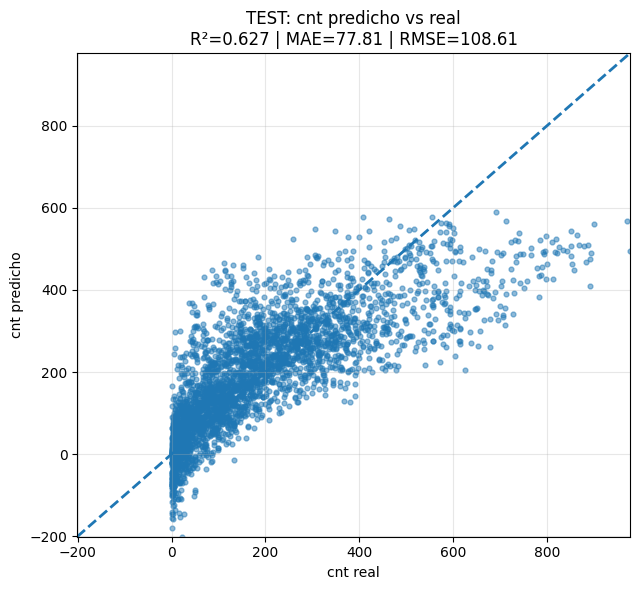

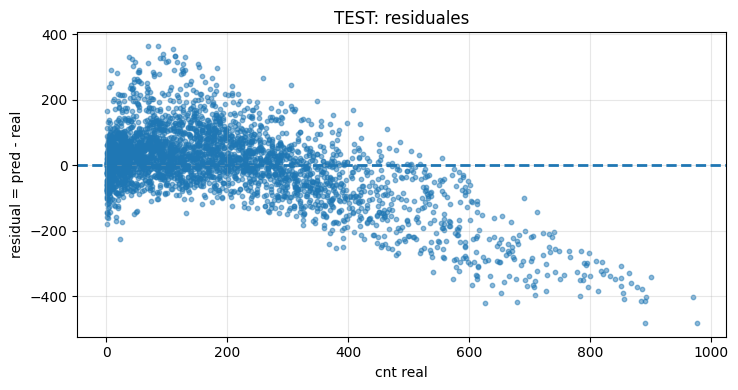

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

def plot_pred_vs_actual(y_true, y_pred, title="Predicho vs Real (cnt)"):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    mae  = mean_absolute_error(y_true, y_pred)
    rmse_v = rmse(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    # --- Scatter y = x ---
    plt.figure(figsize=(6.5, 6))
    plt.scatter(y_true, y_pred, s=12, alpha=0.5)
    lims = [
        min(np.min(y_true), np.min(y_pred)),
        max(np.max(y_true), np.max(y_pred))
    ]
    plt.plot(lims, lims, linestyle="--", linewidth=2)  # línea ideal y=x
    plt.xlim(lims); plt.ylim(lims)
    plt.xlabel("cnt real")
    plt.ylabel("cnt predicho")
    plt.title(f"{title}\nR²={r2:.3f} | MAE={mae:.2f} | RMSE={rmse_v:.2f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title="Residuales (predicho - real)"):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    resid = y_pred - y_true

    plt.figure(figsize=(7.5, 4))
    plt.scatter(y_true, resid, s=10, alpha=0.5)
    plt.axhline(0, linestyle="--", linewidth=2)
    plt.xlabel("cnt real")
    plt.ylabel("residual = pred - real")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- Usa en TEST ---
plot_pred_vs_actual(y_test, y_te_pred, title="TEST: cnt predicho vs real")
plot_residuals(y_test, y_te_pred, title="TEST: residuales")


## **Más Allá de las Reglas: El Perceptron y el Cerebro Artificial 🧠**

### **Motivación / Pregunta Problema:**
Los árboles de decisión son excelentes para problemas definidos por reglas claras y explícitas. Pero, ¿qué pasa con problemas más complejos donde las relaciones no son tan directas? Por ejemplo, predecir un fallo a partir del sutil patrón de vibración de un motor, o clasificar defectos en una imagen por su textura en lugar de su geometría. **¿Podemos crear un modelo inspirado en el cerebro humano que pueda "aprender" patrones complejos sin que le programemos reglas explícitas?**

### **Contexto: El Perceptron, la Neurona Artificial**
La unidad fundamental de las redes neuronales es el **Perceptron**, un modelo matemático inspirado en una neurona biológica. Su funcionamiento se basa en agregar evidencia para tomar una decisión.

1.  **Entradas (Inputs - $x_i$):** Son las características de nuestro proceso (temperatura, presión, velocidad, etc.). Cada una es una señal de entrada.
2.  **Pesos (Weights - $w_i$):** Cada entrada tiene un **peso** asociado, que representa su importancia relativa. Aquí es donde se almacena el "conocimiento" del modelo. Un peso alto significa que la variable es muy influyente en la decisión. El **aprendizaje** consiste en encontrar los valores óptimos para estos pesos.
3.  **Suma Ponderada y Sesgo:** El Perceptron multiplica cada entrada por su peso y suma los resultados. A esta suma se le añade un **sesgo (bias)**, que actúa como un umbral ajustable. El resultado es una única puntuación de evidencia.
    $$\text{Evidencia} = \left(\sum_{i=1}^{n} w_i x_i\right) + b$$
4.  **Función de Activación (El Mecanismo de Decisión):** Esta es la pieza final. La puntuación de evidencia pasa a través de una **función de activación**, que convierte esa puntuación en una decisión final. En el Perceptrón clásico, se usa una **función escalón (Heaviside step function)**: si la evidencia supera el umbral (es positiva), la neurona "se dispara" y emite un 1 (ej. "Defectuoso"); si no, emite un 0 (ej. "Apto"). Es un simple interruptor de "todo o nada".

<div align="center">
<img src="https://cdn.shopify.com/s/files/1/1905/9639/files/Perceptron_1024x1024.webp?v=1704706763" alt="Diagrama de un Perceptron" width="80%">
</div>

### **¿Cómo Aprende? La Regla de Actualización de Pesos**
El aprendizaje es un proceso supervisado e iterativo para encontrar los pesos correctos.

1.  **Inicialización:** Los pesos ($w_i$) y el sesgo ($b$) se inician con valores pequeños y aleatorios.
2.  **Predicción:** Se toma un ejemplo de producción, se calcula la evidencia y la función de activación produce una predicción (0 o 1).
3.  **Cálculo del Error:** Se compara la predicción ($\hat{y}$) con la etiqueta real ($y$). El error es $\text{error} = y - \hat{y}$.
4.  **Ajuste de Pesos:** Aquí ocurre la magia. Cada peso se ajusta ligeramente en la dirección que habría reducido el error. La regla de actualización es:
    $$w_i^{\text{nuevo}} = w_i^{\text{anterior}} + \eta \cdot (y - \hat{y}) \cdot x_i$$
    $$b^{\text{nuevo}} = b^{\text{anterior}} + \eta \cdot (y - \hat{y})$$
    *   $\eta$ es la **tasa de aprendizaje**, un valor pequeño que controla la magnitud del ajuste.
    *   Este ajuste solo se realiza si hubo un error. Si la predicción fue correcta, los pesos no cambian.
5.  **Iteración:** Este proceso se repite para todos los ejemplos del conjunto de entrenamiento, durante muchas **épocas**, hasta que los pesos convergen a una configuración que minimiza el error general.

### **El Fundamento y la Limitación: Problemas Linealmente Separables**
El Perceptrón es la introducción perfecta a las redes neuronales porque es el **átomo** del que se construyen. Sin embargo, un solo Perceptrón es limitado: solo puede resolver problemas **linealmente separables**, es decir, problemas donde se puede trazar una única línea recta (o un hiperplano) para separar perfectamente las clases.

<div align="center">
<img src="https://pbs.twimg.com/media/FMd_0JPXwAQv9r2?format=jpg&name=small" alt="Problemas linealmente separables vs no separables" width="80%">
</div>

### **El Salto a las Redes Neuronales**
La verdadera potencia emerge cuando conectamos estos Perceptrones en **capas**, formando una **Red Neuronal Artificial**.
*   La primera capa de neuronas (capa de entrada) recibe los datos brutos.
*   Las capas intermedias (capas ocultas) toman las salidas de la capa anterior y aprenden a combinarlas en patrones más abstractos y complejos.
*   La capa final (capa de salida) produce la predicción.

Al apilar estas simples unidades de cálculo y utilizar funciones de activación no lineales, la red en su conjunto puede aprender a resolver problemas extremadamente complejos y no lineales, mucho más allá de las capacidades de un solo Perceptrón o un árbol de decisión.

Bibliotecas importadas correctamente.

--- VISUALIZANDO EL EFECTO DEL BIAS ---


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.



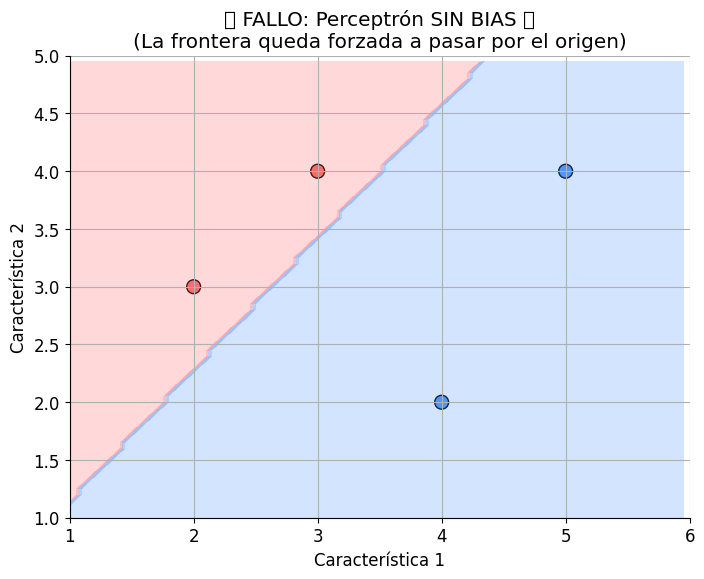

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.



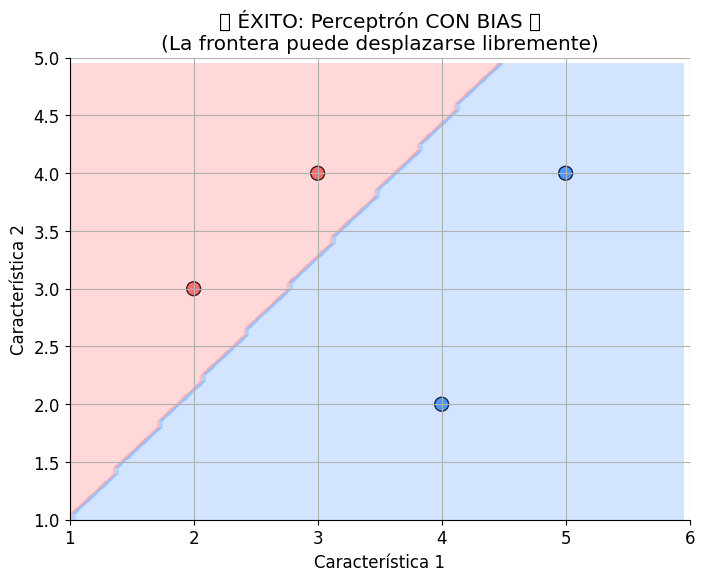

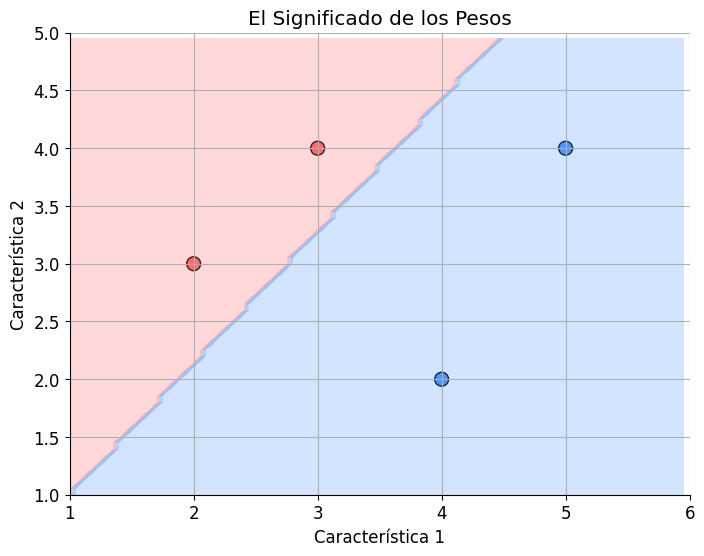

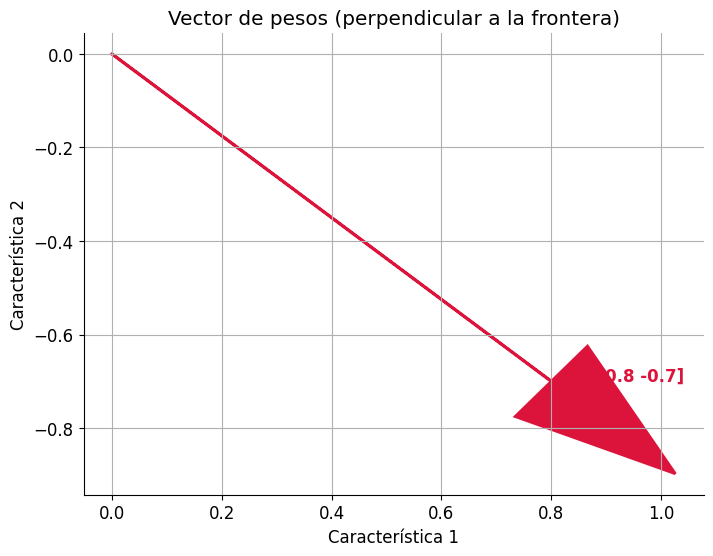


**Pesos y bias finales (con bias):**
w = [ 0.8 -0.7] | b = -0.1


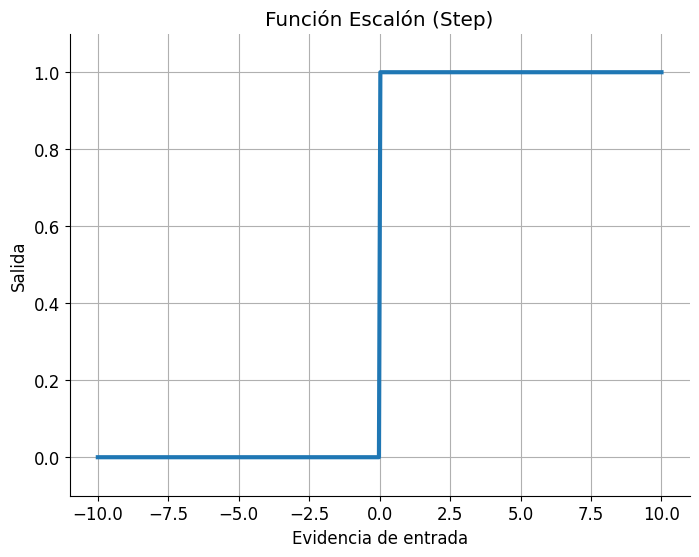

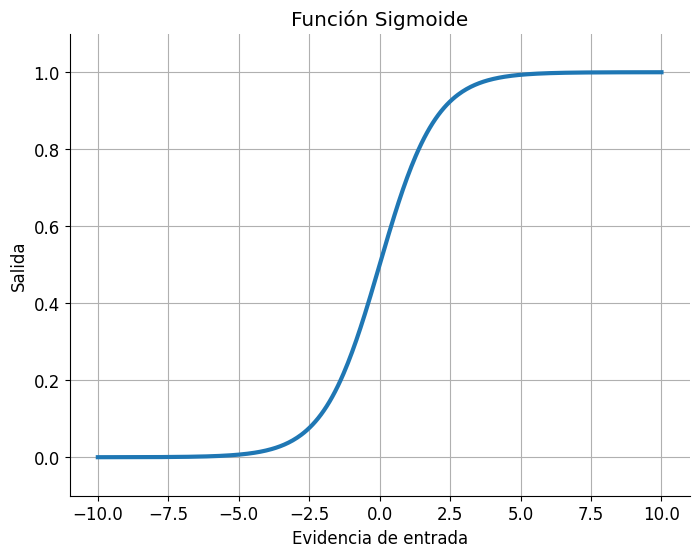

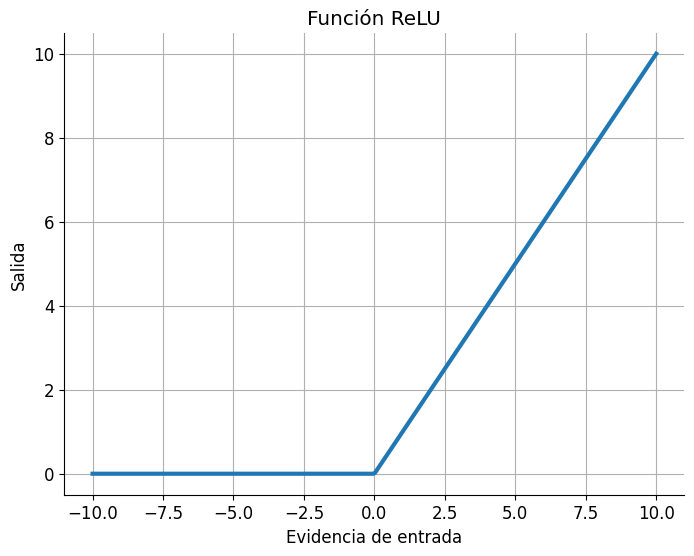

## **Cuadro Comparativo: Perceptrón vs. Árbol de Decisión**

Característica  \
0              **Tipo de Modelo**   
1          **Lógica de Decisión**   
2           **Interpretabilidad**   
3  **Tipo de Límite de Decisión**   
4               **Ideal para...**   

                                       🧠 Perceptrón  \
0                                     Modelo lineal   
1                   Suma ponderada + sesgo (umbral)   
2        Caja gris (los pesos sugieren importancia)   
3                              Lineal (línea/plano)   
4  Problemas linealmente separables; base de redes.   

                          🌳 Árbol de Decisión  
0                     Modelo basado en reglas  
1           Secuencia de reglas "si-entonces"  
2               Caja blanca (flujo explícito)  
3                 No lineal (escalones/cajas)  
4  Interacciones complejas con reglas claras.

In [11]:
# -*- coding: utf-8 -*-
"""
Más Allá de las Reglas: Desmitificando el Perceptrón 🧠
Versión Colab "limpia": sin seaborn, gráficos con matplotlib, y notas didácticas.
"""

# =============================================================================
# Paso 1: Importar Bibliotecas
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from IPython.display import display, Markdown

plt.rcParams.update({
    "figure.figsize": (8, 6),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 12
})
print("Bibliotecas importadas correctamente.")

# =============================================================================
# Paso 2: ¿Qué es el BIAS (Sesgo)? El Poder de Mover la Línea 📏
# =============================================================================
# Problema linealmente separable cuya frontera NO pasa por el origen.
X_sin_bias = np.array([[2, 3], [3, 4], [4, 2], [5, 4]])
y_sin_bias = np.array([0, 0, 1, 1])

class Perceptron:
    def __init__(self, learning_rate=0.1, n_iters=100, use_bias=True):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.use_bias = use_bias
        # Perceptrón clásico: función escalón.
        self.activation_func = lambda x: 1 if x >= 0 else 0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features, dtype=float)
        self.bias = 0.0 if self.use_bias else None

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                linear_output = float(np.dot(x_i, self.weights))
                if self.use_bias:
                    linear_output += float(self.bias)
                y_pred = self.activation_func(linear_output)

                # Regla de actualización del Perceptrón
                update = self.lr * (y[idx] - y_pred)
                self.weights += update * x_i
                if self.use_bias:
                    self.bias += update

    def predict(self, X):
        linear_output = X @ self.weights
        if self.use_bias:
            linear_output = linear_output + self.bias
        return (linear_output >= 0).astype(int)

def plot_decision_boundary(X, y, model, title, step=0.05):
    cmap = ListedColormap(['#FF6B6B', '#4D96FF'])
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolors='k', linewidths=1, s=100)

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, step),
                           np.arange(x2_min, x2_max, step))
    Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.25, cmap=cmap)
    plt.title(title)
    plt.xlabel('Característica 1')
    plt.ylabel('Característica 2')
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.show()

# Entrenamiento sin/ con bias
p_sin_bias = Perceptron(learning_rate=0.1, n_iters=100, use_bias=False)
p_sin_bias.fit(X_sin_bias, y_sin_bias)

p_con_bias = Perceptron(learning_rate=0.1, n_iters=100, use_bias=True)
p_con_bias.fit(X_sin_bias, y_sin_bias)

print("\n--- VISUALIZANDO EL EFECTO DEL BIAS ---")
plot_decision_boundary(
    X_sin_bias, y_sin_bias, p_sin_bias,
    "❌ FALLO: Perceptrón SIN BIAS ❌\n(La frontera queda forzada a pasar por el origen)"
)
plot_decision_boundary(
    X_sin_bias, y_sin_bias, p_con_bias,
    "✅ ÉXITO: Perceptrón CON BIAS ✅\n(La frontera puede desplazarse libremente)"
)

# =============================================================================
# Paso 3: ¿Qué son los PESOS? La Brújula de la Decisión 🧭
# =============================================================================
w = p_con_bias.weights
b = p_con_bias.bias

plot_decision_boundary(X_sin_bias, y_sin_bias, p_con_bias, "El Significado de los Pesos")
# Vector de pesos (flecha) y texto
plt.arrow(0, 0, w[0], w[1], head_width=0.2, head_length=0.3, fc='crimson', ec='crimson', linewidth=2)
plt.text(w[0], w[1], f"  w={np.round(w,2)}", color='crimson', weight='bold')
plt.title("Vector de pesos (perpendicular a la frontera)")
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.show()

print("\n**Pesos y bias finales (con bias):**")
print(f"w = {np.round(w, 3)} | b = {np.round(b, 3)}")

# =============================================================================
# Paso 4: Funciones de Activación ⚡
# =============================================================================
def step_function(x):
    return np.where(x >= 0, 1, 0)

def sigmoid_function(x):
    return 1 / (1 + np.exp(-x))

def relu_function(x):
    return np.maximum(0, x)

x_vals = np.linspace(-10, 10, 400)

# Escalón
plt.figure(figsize=(8, 6))
plt.plot(x_vals, step_function(x_vals), linewidth=3)
plt.title("Función Escalón (Step)")
plt.xlabel("Evidencia de entrada")
plt.ylabel("Salida")
plt.ylim(-0.1, 1.1)
plt.show()

# Sigmoide
plt.figure(figsize=(8, 6))
plt.plot(x_vals, sigmoid_function(x_vals), linewidth=3)
plt.title("Función Sigmoide")
plt.xlabel("Evidencia de entrada")
plt.ylabel("Salida")
plt.ylim(-0.1, 1.1)
plt.show()

# ReLU
plt.figure(figsize=(8, 6))
plt.plot(x_vals, relu_function(x_vals), linewidth=3)
plt.title("Función ReLU")
plt.xlabel("Evidencia de entrada")
plt.ylabel("Salida")
plt.ylim(-0.5, 10.5)
plt.show()

# =============================================================================
# Paso 5: Cuadro Comparativo Final – Perceptrón vs Árbol de Decisión
# =============================================================================
data = {
    'Característica': [
        '**Tipo de Modelo**',
        '**Lógica de Decisión**',
        '**Interpretabilidad**',
        '**Tipo de Límite de Decisión**',
        '**Ideal para...**'
    ],
    '🧠 Perceptrón': [
        'Modelo lineal',
        'Suma ponderada + sesgo (umbral)',
        'Caja gris (los pesos sugieren importancia)',
        'Lineal (línea/plano)',
        'Problemas linealmente separables; base de redes.'
    ],
    '🌳 Árbol de Decisión': [
        'Modelo basado en reglas',
        'Secuencia de reglas "si-entonces"',
        'Caja blanca (flujo explícito)',
        'No lineal (escalones/cajas)',
        'Interacciones complejas con reglas claras.'
    ]
}
comparison_df = pd.DataFrame(data)

display(Markdown('## **Cuadro Comparativo: Perceptrón vs. Árbol de Decisión**'))
display(comparison_df)




## 📌 Método 2 — **MLPRegressor** (no linealidad controlada)

Un **MLP** (red de perceptrones en capas) captura **no linealidades** (p. ej., “hora × clima”). Empieza **pequeño** (1–2 capas), usa **early stopping** y mantén el mismo **pipeline** de datos. Evalúa **MAE/RMSE/R²** y observa la **curva de pérdida** para detectar sobreajuste/estancamiento. Recuerda: mejor precisión a cambio de **menos interpretabilidad**.


== MLPRegressor ==
Train -> MAE: 47.086 | RMSE: 68.547 | R2: 0.858
Test  -> MAE: 47.175 | RMSE: 69.458 | R2: 0.848


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



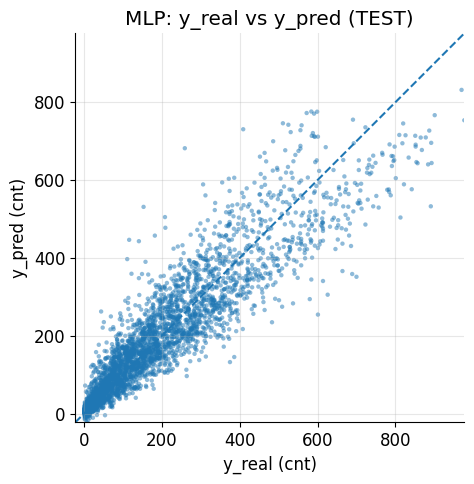

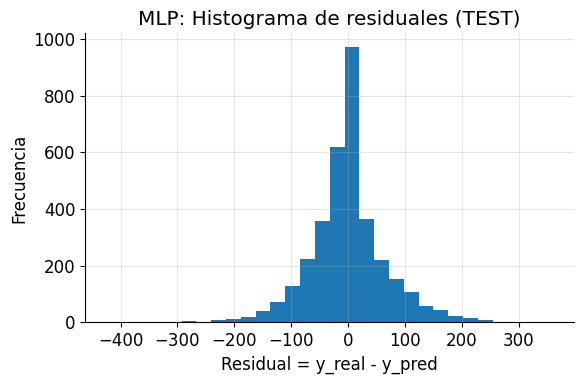

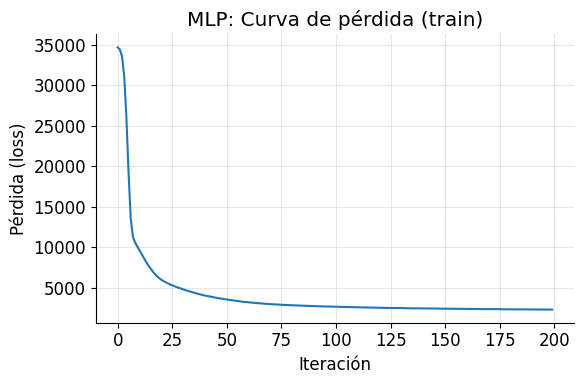

In [12]:
# ============================================================
# MÉTODO 2: MLPRegressor (Red neuronal sencilla para regresión)
# ------------------------------------------------------------
# Qué hace esta celda:
# 1) Entrena un MLP con 1–2 capas pequeñas (no lineal)
# 2) Usa early_stopping para evitar sobreajuste
# 3) Evalúa MAE, RMSE, R2 en train y valid
# 4) Grafica y_real vs y_pred, residuales y curva de pérdida
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mlp = MLPRegressor(
    hidden_layer_sizes=(16, 8, 4),  # empieza simple; puedes ajustar
    activation="relu",
    solver="adam",
    learning_rate_init=1e-3,
    max_iter=200,
    early_stopping=True,      # usa un conjunto interno de validación
    validation_fraction=0.2,  # 20% del conjunto de entrenamiento
    n_iter_no_change=10,
    random_state=42
)
mlp.fit(X_train_pre, y_train)


# --- Predicciones ---
y_tr_pred = mlp.predict(X_train_pre)
y_te_pred = mlp.predict(X_test_pre)

# --- Métricas ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("== MLPRegressor ==")
print(f"Train -> MAE: {mean_absolute_error(y_train, y_tr_pred):.3f} | RMSE: {rmse(y_train, y_tr_pred):.3f} | R2: {r2_score(y_train, y_tr_pred):.3f}")
print(f"Test  -> MAE: {mean_absolute_error(y_test,  y_te_pred):.3f} | RMSE: {rmse(y_test,  y_te_pred):.3f} | R2: {r2_score(y_test,  y_te_pred):.3f}")

# --- Gráfico 1: y_real vs y_pred (TEST) ---
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_te_pred, s=10, alpha=0.5, edgecolor='none')
lims = [min(np.min(y_test), np.min(y_te_pred)), max(np.max(y_test), np.max(y_te_pred))]
plt.plot(lims, lims, linestyle='--', linewidth=1.5)
plt.xlim(lims); plt.ylim(lims); plt.gca().set_aspect('equal', adjustable='box')
plt.title("MLP: y_real vs y_pred (TEST)")
plt.xlabel("y_real (cnt)")
plt.ylabel("y_pred (cnt)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Gráfico 2: residuales (TEST) ---
resid = y_test - y_te_pred
plt.figure(figsize=(6,4))
plt.hist(resid, bins=30)
plt.title("MLP: Histograma de residuales (TEST)")
plt.xlabel("Residual = y_real - y_pred")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Gráfico 3: curva de pérdida (entrenamiento) ---
if hasattr(mlp, "loss_curve_"):
    plt.figure(figsize=(6,4))
    plt.plot(mlp.loss_curve_)
    plt.title("MLP: Curva de pérdida (train)")
    plt.xlabel("Iteración")
    plt.ylabel("Pérdida (loss)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No se encontró 'loss_curve_' (versión de sklearn o configuración distinta).")


Ejecutando GridSearchCV (esto puede tardar un poco)...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
GridSearchCV tomó: 926.14 s

== Resultado de la búsqueda (CV) ==
Mejores hiperparámetros: {'alpha': 0.001, 'hidden_layer_sizes': (16, 8, 4), 'learning_rate_init': 0.001}
RMSE CV (aprox): 72.97396365016901

== MLP (MEJOR MODELO) ==
Train -> MAE: 46.816 | RMSE: 68.336 | R2: 0.859
Test  -> MAE: 46.512 | RMSE: 68.550 | R2: 0.852


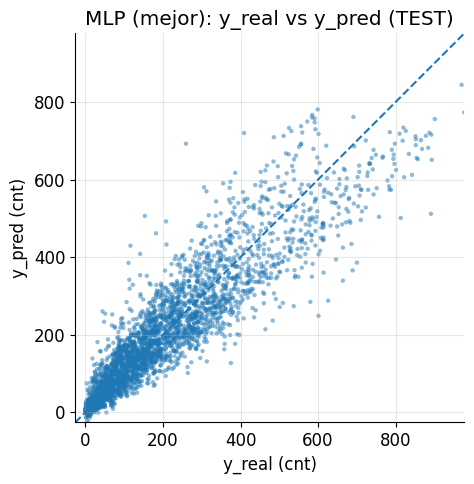

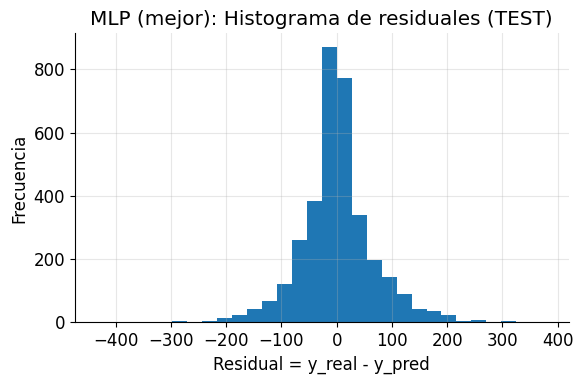

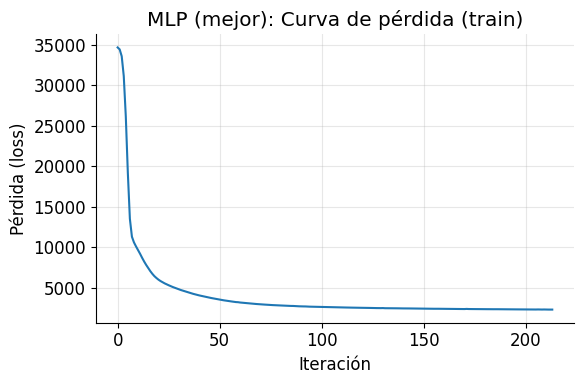

In [ ]:
# ============================================================
# BÚSQUEDA DE HIPERPARÁMETROS Y EVALUACIÓN DEL MEJOR MLP
# ------------------------------------------------------------
# Qué hace esta celda:
# 1) Define un MLP base con early_stopping y validación interna (20%).
# 2) Ejecuta GridSearchCV (cv=3, SIN cosas temporales) optimizando RMSE.
# 3) Muestra los mejores hiperparámetros y el RMSE de CV.
# 4) Reentrena el MEJOR MLP en TODO el set de entrenamiento (X_train_pre, y_train).
# 5) Evalúa en train y en tu holdout de validación (X_valid_pre, y_valid).
# 6) Grafica y_real vs y_pred, residuales y la curva de pérdida del mejor modelo.
# ------------------------------------------------------------
# Requisitos:
# - Haber corrido la celda de preparación para tener X_train_pre, X_valid_pre,
#   y_train, y_valid. (No tocamos nada temporal aquí.)
# - Haber corrido tu celda anterior del MLP si quieres comparar manualmente.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

# --- Función auxiliar de RMSE ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# 1) Estimador base (con early_stopping interno)
mlp_base = MLPRegressor(
    activation="relu",
    solver="adam",
    max_iter=600,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    random_state=42
)

# 2) Parrilla de hiperparámetros
param_grid = {
    "hidden_layer_sizes": [
        (16, 8, 4),   # tu config actual
        (32, 16),     # menos profundo, más ancho
        (32, 16, 8),  # un poco mayor capacidad
        (16, 8)       # más simple
    ],
    "alpha": [1e-4, 1e-3, 1e-2],                 # regularización L2
    "learning_rate_init": [1e-3, 5e-4, 1e-4]     # tasa de aprendizaje inicial
}

# 3) GridSearchCV
grid = GridSearchCV(
    estimator=mlp_base,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # sklearn maximiza -> usamos neg-RMSE
    cv=3,
    n_jobs=-1,
    verbose=1
)



print("Ejecutando GridSearchCV (esto puede tardar un poco)...")
grid.fit(X_train_pre, y_train)


t0 = time.perf_counter()
grid.fit(X_train_pre, y_train)
t1 = time.perf_counter()
print(f"GridSearchCV tomó: {t1 - t0:.2f} s")

print("\n== Resultado de la búsqueda (CV) ==")
print("Mejores hiperparámetros:", grid.best_params_)
print("RMSE CV (aprox):", -grid.best_score_)

# 4) Reentrenar el MEJOR modelo en TODO el set de entrenamiento
best_mlp = grid.best_estimator_
best_mlp.fit(X_train_pre, y_train)

# 5) Evaluación final en train y en HOLDOUT (TEST)
y_tr_pred = best_mlp.predict(X_train_pre)
y_te_pred = best_mlp.predict(X_test_pre)

print("\n== MLP (MEJOR MODELO) ==")
print(f"Train -> MAE: {mean_absolute_error(y_train, y_tr_pred):.3f} | RMSE: {rmse(y_train, y_tr_pred):.3f} | R2: {r2_score(y_train, y_tr_pred):.3f}")
print(f"Test  -> MAE: {mean_absolute_error(y_test,  y_te_pred):.3f} | RMSE: {rmse(y_test,  y_te_pred):.3f} | R2: {r2_score(y_test,  y_te_pred):.3f}")

# 6) Gráficos del mejor modelo
# --- y_real vs y_pred (TEST) ---
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_te_pred, s=10, alpha=0.5, edgecolor='none')
lims = [min(np.min(y_test), np.min(y_te_pred)), max(np.max(y_test), np.max(y_te_pred))]
plt.plot(lims, lims, linestyle='--', linewidth=1.5)
plt.xlim(lims); plt.ylim(lims); plt.gca().set_aspect('equal', adjustable='box')
plt.title("MLP (mejor): y_real vs y_pred (TEST)")
plt.xlabel("y_real (cnt)")
plt.ylabel("y_pred (cnt)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Histograma de residuales (TEST) ---
resid = y_test - y_te_pred
plt.figure(figsize=(6,4))
plt.hist(resid, bins=30)
plt.title("MLP (mejor): Histograma de residuales (TEST)")
plt.xlabel("Residual = y_real - y_pred")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Curva de pérdida del mejor MLP (si está disponible) ---
if hasattr(best_mlp, "loss_curve_"):
    plt.figure(figsize=(6,4))
    plt.plot(best_mlp.loss_curve_)
    plt.title("MLP (mejor): Curva de pérdida (train)")
    plt.xlabel("Iteración")
    plt.ylabel("Pérdida (loss)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No se encontró 'loss_curve_' en el mejor modelo.")




In [ ]:

# ============================================================
# RANDOM SEARCH (ESPACIO GRANDE) + EVALUACIÓN DEL MEJOR MLP
# ------------------------------------------------------------
# Qué hace esta celda:
# 1) Define un MLP base con early_stopping y validación interna.
# 2) RandomizedSearchCV con un espacio AMPLIO:
#    - Muchas arquitecturas (1–4 capas, anchos 8–256).
#    - activation en {"relu","tanh"}.
#    - alpha ~ LogUniform[1e-6, 1e-1]
#    - learning_rate_init ~ LogUniform[1e-5, 5e-2]
#    - learning_rate en {"constant","adaptive"}.
# 3) n_iter alto (p.ej., 200). Ajusta a más si quieres aún más búsqueda.
# 4) Reentrena el mejor y evalúa en holdout (X_valid_pre, y_valid).
# 5) Gráficas: y_real vs y_pred, residuales, curva de pérdida.
# ------------------------------------------------------------
# Requisitos: haber ejecutado la preparación (X_train_pre, X_valid_pre, y_train, y_valid).
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import loguniform
import time


# --- Función auxiliar de RMSE ---
def rmse(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    return np.sqrt(mean_squared_error(y_true, y_pred))

# 1) Estimador base con early_stopping (corte automático por validación interna)
mlp_base = MLPRegressor(
    activation="relu",
    solver="adam",
    max_iter=1200,           # alto para permitir convergencia en candidatos exigentes
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=15,
    random_state=42
)

# 2) ESPACIO GRANDE DE ARQUITECTURAS
arch_candidates = [
    # 1 capa
    (8,), (16,), (32,), (64,), (128,), (256,),
    # 2 capas
    (16,8), (32,16), (64,32), (128,64), (256,128),
    (32,8), (64,16), (128,32), (256,64),
    # 3 capas
    (16,8,4), (32,16,8), (64,32,16), (128,64,32), (256,128,64),
    (32,16,4), (64,16,8), (128,32,8), (256,64,16),
    # 4 capas
    (32,16,8,4), (64,32,16,8), (128,64,32,16)
]

# 3) Distribuciones amplias (log-uniformes) para regularización y LR
param_distributions = {
    "hidden_layer_sizes": arch_candidates,
    "activation": ["relu", "tanh"],
    "alpha": loguniform(1e-6, 1e-1),             # L2 entre 1e-6 y 1e-1
    "learning_rate": ["constant", "adaptive"],
    "learning_rate_init": loguniform(1e-5, 5e-2) # entre 1e-5 y 5e-2
}

# 4) RandomizedSearchCV con n_iter grande
rand_search = RandomizedSearchCV(
    estimator=mlp_base,
    param_distributions=param_distributions,
    n_iter=200,                              # puedes subir a 300/400 si el tiempo lo permite
    scoring="neg_root_mean_squared_error",   # optimizamos RMSE (negativo porque sklearn maximiza)
    cv=3,                                    # 3 folds (no temporal)
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Ejecutando RandomizedSearchCV con espacio AMPLIO...")
rand_search.fit(X_train_pre, y_train)

t0 = time.perf_counter()
rand_search.fit(X_train_pre, y_train)
t1 = time.perf_counter()
print(f"RandomizedSearchCV tomó: {t1 - t0:.2f} s")

print("\n== Resultado de la búsqueda aleatoria (CV) ==")
print("Mejores hiperparámetros:", rand_search.best_params_)
print("RMSE CV (aprox):", -rand_search.best_score_)

# 5) Reentrenar el MEJOR modelo en TODO el set de entrenamiento y evaluar en TEST
best_mlp = rand_search.best_estimator_
best_mlp.fit(X_train_pre, y_train)

y_tr_pred = best_mlp.predict(X_train_pre)
y_te_pred = best_mlp.predict(X_test_pre)

print("\n== MLP (MEJOR MODELO — Random Search amplio) ==")
print(f"Train -> MAE: {mean_absolute_error(y_train, y_tr_pred):.3f} | RMSE: {rmse(y_train, y_tr_pred):.3f} | R2: {r2_score(y_train, y_tr_pred):.3f}")
print(f"Test  -> MAE: {mean_absolute_error(y_test,  y_te_pred):.3f} | RMSE: {rmse(y_test,  y_te_pred):.3f} | R2: {r2_score(y_test,  y_te_pred):.3f}")

# 6) Gráficas del mejor modelo (TEST)
# --- y_real vs y_pred (TEST) ---
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_te_pred, s=10, alpha=0.5, edgecolor='none')
lims = [min(np.min(y_test), np.min(y_te_pred)), max(np.max(y_test), np.max(y_te_pred))]
plt.plot(lims, lims, linestyle='--', linewidth=1.5)
plt.xlim(lims); plt.ylim(lims); plt.gca().set_aspect('equal', adjustable='box')
plt.title("MLP (mejor, Random Search amplio): y_real vs y_pred (TEST)")
plt.xlabel("y_real (cnt)")
plt.ylabel("y_pred (cnt)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Histograma de residuales (TEST) ---
resid = y_test - y_te_pred
plt.figure(figsize=(6,4))
plt.hist(resid, bins=30)
plt.title("MLP (mejor, Random Search amplio): Histograma de residuales (TEST)")
plt.xlabel("Residual = y_real - y_pred")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Curva de pérdida del mejor MLP (si está disponible) ---
if hasattr(best_mlp, "loss_curve_"):
    plt.figure(figsize=(6,4))
    plt.plot(best_mlp.loss_curve_)
    plt.title("MLP (mejor, Random Search amplio): Curva de pérdida (train)")
    plt.xlabel("Iteración")
    plt.ylabel("Pérdida (loss)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No se encontró 'loss_curve_' en el mejor modelo.")






Ejecutando RandomizedSearchCV con espacio AMPLIO...
Fitting 3 folds for each of 200 candidates, totalling 600 fits
